In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/eli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Unigrams

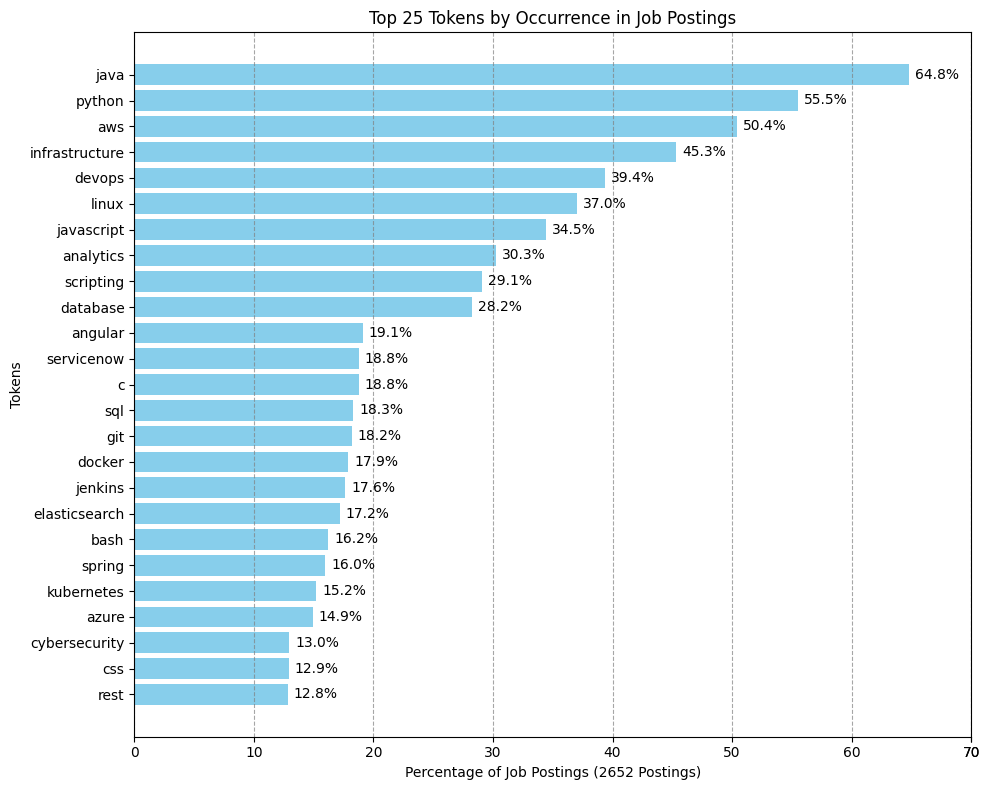

Total job postings count: 2652
Top 150 Tokens (Token - Percentage of Job Postings Token is Mentioned):
java - 64.82%
python - 55.54%
aws - 50.41%
infrastructure - 45.32%
devops - 39.40%
linux - 36.99%
javascript - 34.46%
analytics - 30.28%
scripting - 29.11%
database - 28.24%
angular - 19.12%
servicenow - 18.78%
c - 18.78%
sql - 18.33%
git - 18.17%
docker - 17.87%
jenkins - 17.65%
elasticsearch - 17.19%
bash - 16.21%
spring - 15.99%
kubernetes - 15.23%
azure - 14.93%
cybersecurity - 12.97%
css - 12.93%
rest - 12.82%
cots - 12.75%
scripts - 12.67%
google - 12.56%
html - 12.37%
unix - 12.03%
junit - 10.97%
react - 10.71%
ansible - 9.99%
gitlab - 9.77%
apis - 9.69%
protocols - 9.58%
modeling - 9.28%
oracle - 9.28%
servers - 9.20%
ui - 8.90%
cisco - 8.79%
gots - 8.48%
virtualization - 8.48%
sharepoint - 8.30%
cno - 7.99%
apache - 7.92%
api - 7.88%
github - 7.88%
rds - 7.77%
distributed - 7.69%
embedded - 7.65%
splunk - 7.54%
ms - 7.50%
excel - 7.50%
springboot - 7.39%
rf - 7.32%
relational

In [300]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType, ArrayType
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

spark = SparkSession.builder.appName("JobDescriptions").getOrCreate()

# Load NLTK stop words and define custom stop words
nltk_stop_words = set(stopwords.words('english'))
custom_stop_words = {'follows', 'iterative', 'builds', 'itil', 'rules', 'innovating', 'stop', 'invest', 'personally', 'unleash','example', 'commands', 'worked', 'logical', 'decomposition', 'aware', 'sw', 'involving', 'according', 'settle', 'adhere','recruitment', 'brings', 'happiness', 'closure', 'eighteen', 'issued', 'electronics', 'accepts', 'telecommute', 'shortened', 'represent','apps', 'ambiguity', 'interactive', 'departments', 'differentiator', 'script', 'commonly', 'condition', 'answer', 'proper', 'unlimited', 'defend','b', 'referrer', 'packed', 'kernel', 'legally', 'yrs', 'accuracy', 'laurel', 'esop', 'acceptable', 'detection', 'formally','bethesda', 'mechanical', 'addressing', 'assessing', 'workloads', 'doctorate', 'survey', 'increase', 'larger', 'regularly', 'campaign', 'alternate','brief', 'demonstrable', 'goal', 'depends', 'bugs', 'encourages', 'pushed', 'prized', 'modification', 'peer', 'realizing', 'tysons', 'incorporated','enthusiasm', 'district', 'save', 'nuclear', 'foundry', 'redirected', 'strength', 'unfaltering', 'abroad', 'vigilant', 'factory', 'president', 'vibrant', 'mapping', 'handle','breadth', 'dissemination', 'sp', 'eap', 'roadmaps', 'achieving', 'restricted', 'sponsored', 'veterans', 'side', 'optimizing', 'translating', 'authority', 'associates', 'screening','advancing', 'prohibits', 'fundamental', 'transitioned', 'info', 'became', 'brought', 'sum', 'vice', 'prodigy', 'waiting', 'placed', 'approached', 'thanks', 'recertification', 'releases', 'homeland','hold', 'streaming', 'deeply', 'chemistry', 'clean', 'embark', 'teleworking', 'transport', 'administer', 'cause', 'logistics', 'advantage', 'upcoming', 'differences', 'extra', 'designated', 'logging','inventive', 'insatiable', 'stealth', 'cognitive', 'atlantic', 'bombers', 'sccm', 'offensive', 'unproven', 'subversion', 'comply', 'ad', 'w', 'zero', 'itsm', 'joint', 'micro', 'seek', 'preparing','audiences', 'regulations', 'thing', 'sign', 'largest', 'facilities', 'hawaii', 'freedom', 'altamira', 'covid','hair', 'ocean', 'emphasizes', 'managed', 'degrees', 'accept', 'routine', 'examples', 'might', 'demands', 'math','true', 'pass', 'speed', 'participant', 'train', 'cryptographic', 'knowledgeable', 'e', 'scholar', 'necessity', 'territory', 'semiconductor','shield', 'layer', 'bar', 'powerpoint', 'updated', 'leaders', 'media', 'accomplish', 'coordinates', 'advice', 'tactical', 'image','desk', 'cares', 'substitute', 'adobe', 'vested', 'twelve', 'opentext', 'classification', 'dhcp', 'baselines', 'shorten', 'previously', 'intelligent', 'moon','mtsi', 'funded', 'affected', 'prospective', 'anticipating', 'recall', 'referred', 'carefirst', 'meets', 'greatest', 'filled', 'transitioning', 'technicians', 'given', 'earth','impossible', 'prohibited', 'formed', 'unwavering', 'landing', 'leaves', 'intellectual', 'connectivity', 'allocate', 'ensures', 'instructions', 'manages', 'depend', 'solves', 'upgrading', 'art', 'interview','collaborates', 'giving', 'credentials', 'social', 'subcontractor', 'submit', 'give', 'upskilling', 'wait','ce', 'warfighter', 'generations', 'perfect', 'acquired', 'thank', 'mentality', 'revolutionary', 'expand', 'compatibility', 'points','evaluates', 'mid', 'engagement', 'ppo', 'insight', 'recovery', 'unless', 'wbs', 'little', 'distribution', 'segment','easy', 'event', 'researches', 'internals', 'uniformed', 'york', 'assured', 'cca', 'actionable', 'mitigation', 'utility', 'measurement','firms', 'ops', 'researching', 'threshold', 'periodically', 'divergent', 'unrivaled', 'certain', 'interaction', 'director', 'implements', 'payments', 'combat','ngmc', 'starts', 'prides', 'thorough', 'weekly', 'vendors', 'briefing', 'presentations', 'ia', 'standalone', 'reusable', 'designers', 'recharge', 'commensurate','preferably', 'enabling', 'aim', 'northern', 'assignments', 'duty', 'hat', 'running', 'providers', 'advise', 'demanding', 'closing', 'acknowledges', 'happens', 'encompass','resumes', 'happy', 'ai', 'eager', 'knowing', 'modernize', 'unified', 'completeness', 'behind', 'ctc', 'id', 'xcelerate', 'recognize', 'tomorrow', 'expectations', 'lean', 'provisioning', 'architects','name', 'challenged', 'mentor', 'cj', 'curiosity', 'incorporate', 'proactive', 'voice','vital', 'specifically', 'comparable', 'thinking', 'discounted', 'quantum', 'layoff', 'yes', 'increases', 'visionist','annualized', 'energy', 'periods', 'connection', 'parkway', 'whose', 'conjunction', 'sustain', 'types', 'teammates', 'acceptance','innovate', 'markets', 'realizable', 'governance', 'passwords', 'earn', 'participates', 'frequently', 'preliminary', 'involves', 'ever','measures', 'overcome', 'accommodate', 'supply', 'inferred', 'unambiguous', 'bdd', 'invent', 'fearlessly', 'seconds', 'administrative','resides', 'decades', 'considering', 'eoe', 'unparalleled', 'extend', 'verified', 'internally', 'ease', 'wireless', 'check', 'executive','word', 'stacks', 'collaboratively', 'logically', 'sessions', 'files', 'connect', 'play', 'modifies', 'absence', 'apart', 'conmd', 'scaled','perks', 'sensitive', 'costs', 'seamless', 'deadlines', 'greater', 'relies', 'discovery', 'involved', 'material', 'responsive', 'findings', 'req','wartime', 'initiative', 'records', 'phone', 'civil', 'imp', 'specialists', 'flight', 'paced', 'cluster', 'single', 'innovations', 'mechanism','positive', 'citizens', 'entity', 'foundation', 'rmf', 'interacting', 'california', 'yet', 'completion', 'timeline', 'condensed', 'character', 'bluehalo', 'ambitions','short', 'practical', 'month', 'firm', 'relentless', 'creativity', 'deadline', 'accountability', 'equitable', 'fsp', 'visible', 'visiting', 'lengthy', 'programmatic', 'human','empowers', 'call', 'estimated', 'sounds', 'ownership', 'continuously', 'especially', 'hard', 'behavior', 'interests', 'mda', 'regardless', 'gaps', 'choice', 'pursue','faith', 'modifying', 'previous', 'practice', 'gaining', 'colorado', 'implemented', 'presenting', 'difficult', 'insights', 'format', 'resolving', 'confidentiality', 'challenge', 'verifiable', 'bold','dev', 'device', 'scenarios', 'placement', 'comptia', 'controls', 'dependencies', 'link', 'courage', 'feels', 'response', 'generating', 'possibly', 'exchange', 'specializing', 'thrives', 'ahead', 'toward', 'harassment',
'cs', 'determining', 'push', 'statements', 'hires', 'analyses', 'case', 'approve', 'blue','termination', 'jovian', 'navstar', 'reading', 'iii', 'exploitation', 'endless', 'fall', 'harnessing','query', 'continue', 'gathering', 'communicating', 'exposure', 'back', 'interactions', 'earned', 'massive', 'manner', 'openings','list', 'trade', 'official', 'adoption', 'issue', 'self', 'notice', 'advancements', 'customize', 'enabled', 'another','taking', 'routing', 'map', 'even', 'milestones', 'messaging', 'due', 'compute', 'breakdown', 'backgrounds', 'subsystem','partnership', 'think', 'tradecraft', 'chn', 'synergy', 'limitless', 'foster', 'recent', 'exploit', 'artificial', 'prioritizes', 'determination','offered', 'migration', 'radio', 'retention', 'knows', 'countries', 'elicitation', 'ultimate', 'immediately', 'engage', 'failure', 'prototypes', 'amounts', 'last','reference', 'searching', 'made', 'study', 'supervision', 'mclean', 'ii', 'monthly', 'explore', 'succeed', 'install', 'let', 'websites', 'sectors','containers', 'setting', 'disposal', 'lactation', 'te', 'technological', 'reach', 'answers', 'configurations', 'dataflow', 'serving', 'chart', 'gather', 'threat','awareness', 'cap', 'amazing', 'rewarding', 'developmental', 'perspectives', 'analyst', 'incredible', 'utilization', 'assisting', 'shown', 'linthicum', 'electronic', 'civilian', 'amount', 'timely','technically', 'usability', 'rapidly', 'incorporates', 'accrue', 'report', 'contributing', 'nefits', 'already', 'architecting', 'vendor', 'entire', 'backup', 'rather', 'tuning', 'fort','subsidized', 'starting', 'allowance', 'enhancing', 'driving', 'genetics', 'containerized', 'sections', 'changing', 'course', 'projected', 'sound', 'discover', 'premium', 'cross', 'usa','families', 'cutting', 'bridge', 'stories', 'heavily', 'interesting', 'align', 'demonstration', 'automating', 'uses', 'advisor', 'selection', 'percentage', 'profit', 'vaccination', 'ecp','whole', 'followed', 'aligning', 'oversight', 'importance', 'applied', 'contingent', 'superior', 'accrued', 'hii', 'formulating', 'comfortable', 'command', 'protocol', 'advises', 'dulles','host', 'incentive', 'guidelines', 'bi', 'desire', 'outcomes', 'elements', 'satisfaction', 'recently', 'huge', 'extended', 'persons', 'ways', 'transform', 'childbirth', 'privacy','maintainability', 'nature', 'things', 'impacts', 'ranges', 'load', 'soap', 'fun', 'conops', 'mentorship', 'oral', 'performs', 'evaluating', 'legal', 'continued', 'fortune', 'formats', 'tailored', 'representative', 'traceability','reality', 'numerous', 'object', 'logic', 'error', 'emphasis', 'premiums', 'materials', 'international', 'expected', 'affordability', 'got', 'highest', 'educational', 'fast', 'installing', 'identified', 'holiday', 'scientists', 'something','desktop', 'briefings', 'displayed', 'ts', 'resiliency', 'deployed', 'participating', 'employs', 'intended', 'boeing','box', 'federally', 'approximately', 'defining', 'studio', 'accurate', 'consistently', 'named', 'promotion', 'demand','continually', 'subsystems', 'ci', 'break', 'ccb', 'container', 'compatible', 'leader', 'supportive', 'cornerstone', 'respect','professionally', 'validate', 'internet', 'creation', 'structures', 'contractual', 'feedback', 'iat', 'mechanisms', 'presentation', 'satisfies','matching', 'real', 'assists', 'nontraditional', 'farthest', 'financing', 'galaxy', 'post', 'union', 'advancement', 'read','truly', 'intern', 'characteristics', 'careers', 'attractive', 'hands', 'sites', 'point', 'inclusivity', 'collective', 'differentiated', 'among','likely', 'fulfill', 'confident', 'celebrate', 'towards', 'minimal', 'content', 'empower', 'allocated', 'fulfills', 'live', 'forward', 'teamwork','private', 'environmental', 'guaranteed', 'pioneering', 'assigned', 'managers', 'either', 'scalability', 'means', 'contractors', 'evolving', 'describe', 'colleagues','red', 'structured', 'fertility', 'boundaries', 'deployments', 'aerospace', 'progress', 'modules', 'prototyping', 'vary', 'impactful', 'consistent', 'special','rapid', 'efficiently', 'directory', 'accessibility', 'video', 'simulation', 'chance', 'encouraged', 'sure', 'sca', 'sea', 'functioning', 'tackle','toughest', 'option', 'timing', 'sr', 'visual', 'resume', 'dc', 'transformative', 'retaining', 'spirit', 'approved', 'continuing', 'loan', 'flows','remotely', 'submissions', 'orchestration', 'assessments', 'readiness', 'vulnerabilities', 'extract', 'tasking', 'forefront', 'capable', 'jobs', 'sprint', 'tech', 'award','budgets', 'interfacing', 'updating', 'line', 'markon', 'feasibility', 'move', 'allow', 'prepare', 'clearly', 'safer', 'establishing', 'strict', 'pride', 'continues', 'disabled', 'incentives','mix', 'shared', 'reduce', 'never', 'telework', 'operates', 'accepted', 'transparency', 'implied','effort', 'update', 'less', 'takes', 'hsa', 'ged', 'treatment', 'sponsorships', 'affirmative', 'disciplines','friend', 'makeup', 'vanguard', 'uhc', 'featuring', 'inux', 'cbtnuggets', 'vsp', 'enterprises', 'become','student', 'willing', 'motivated', 'mobility', 'influence', 'fields', 'execute', 'ltd', 'academy', 'concordia','optimization', 'reflected', 'holders', 'dollars', 'specialized', 'posted', 'enhanced', 'much', 'tware', 'land', 'coworker', 'promote','matched', 'capacity', 'located', 'metrics', 'consider', 'tier', 'fs', 'daunting', 'ethnicity', 'offices', 'force', 'communicates','drives', 'branch', 'sof', 'max', 'store', 'llc', 'division', 'love', 'improvements', 'meaningful', 'since', 'rates','home', 'creative', 'coordinating', 'clusters', 'signature', 'optimum', 'actively', 'generation', 'scheduling', 'proactively', 'patterns', 'fair','worldwide', 'months', 'release', 'air', 'twenty', 'l', 'discrimination', 'reporting', 'eight', 'mobile', 'signals', 'creed', 'sustainment', 'directing','stay', 'workflow', 'click', 'budget', 'alongside', 'relocation', 'mitre', 'junior', 'fulfilling', 'file', 'smarter', 'putting', 'parsons', 'subsidiary', 'authorization','board', 'transfer', 'quicker', 'expect', 'labs', 'quickly', 'risks', 'feel', 'sources', 'interacts', 'accommodations', 'cleared', 'covered', 'imagine', 'overseers', 'accessible', 'path','soa', 'choices', 'though', 'spanning', 'translate', 'produce', 'discriminate','satellite', 'early', 'reward', 'facing', 'requests', 'strive', 'locations', 'empowering', 'interact', 'upgrade','automate', 'libraries', 'trends', 'cost', 'function', 'accreditation', 'diploma', 'oriented', 'wage', 'request', 'collaborating','act', 'array', 'keeping', 'interpersonal', 'microelectronics', 'gitflow', 'events', 'recognized', 'os', 'seta', 'cohesion', 'assets', 'identifying','experiences', 'story', 'contact', 'typically', 'constructs', 'optimal', 'categories', 'tempo', 'window', 'saic', 'configuring', 'scale', 'present','serves', 'opening', 'focuses', 'accounts', 'outcome', 'integrator', 'reston', 'purpose', 'gain', 'derived', 'established', 'attention', 'follow', 'darkstar', 'generate', 'protection','target', 'administrator', 'matters', 'executives', 'interested', 'via', 'reaches', 'refer', 'disabilities', 'armed', 'completed', 'ancestry', 'consequence', 'fill', 'sector', 'prioritize', 'physics','rewards', 'hybrid', 'sick', 'capture', 'autonomy', 'bonuses', 'healthy', 'co','willingness', 'signal', 'fourteen', 'select', 'owned', 'arcfield', 'rate', 'solid', 'sme','long', 'columbia', 'inclusion', 'discretionary', 'depending', 'strategy', 'difference', 'uc', 'requiring','architectural', 'portfolio', 'authentication', 'independent', 'transition', 'limitations', 'strategies', 'associate', 'passion','domain', 'detail', 'investigate', 'built', 'meade', 'facilitate', 'additionally', 'voluntary', 'dependents','boot', 'phases', 'criteria', 'documenting', 'cyberspace', 'manufacturing', 'estimation', 'consequences', 'analytical', 'conducting','someone', 'conducts', 'successfully', 'contracting', 'trust', 'roles', 'diagrams', 'journey', 'globe', 'interest', 'establish','modernization', 'companies', 'traditional', 'decision', 'lasting', 'nexus', 'determined', 'awards', 'noblis', 'always', 'baseline', 'forms','hr', 'cm', 'flex', 'reviewing', 'country', 'nice', 'applying', 'allies', 'shift', 'mental', 'systolic', 'met','sharing', 'done', 'configure', 'guide', 'currently', 'transformation', 'earlier', 'estimate', 'conflicts', 'mathematical', 'everything', 'none','makes', 'courses', 'formal', 'expense', 'measure', 'reliable', 'growing', 'structure', 'exceed', 'resolves', 'bringing', 'recognition','manager', 'enjoy', 'predict', 'competencies', 'analyzes', 'reflects', 'owners', 'spending', 'laws', 'questions', 'believe', 'bargaining','joining', 'reasonably', 'overhead', 'maximum', 'oversee', 'latest', 'utilizes', 'right', 'actions', 'hire', 'consultants', 'cybercore', 'proof','anticipated', 'priority', 'assess', 'devices', 'see', 'hibernate', 'scalable', 'hired', 'investment', 'electrical', 'prime', 'offering', 'statement', 'alternatives','beyond', 'purchase', 'topics', 'considers', 'mathematics','synthesis', 'safety', 'items', 'front', 'enhances', 'studies', 'choose','fit', 'domains', 'preparation', 'determine', 'terms', 'challenging', 'investigation', 'power', 'vesting','allocation', 'utilize', 'edge', 'collection', 'errors', 'direction', 'talent', 'extensive', 'low','enable', 'reliability', 'efficiency', 'applicant', 'shape', 'effective', 'optimize', 'term', 'sci','outside', 'improvement', 'recommend', 'headquartered', 'accenture', 'approach', 'directly', 'history', 'fostering', 'founded', 'record','bachelors', 'usd', 'vulnerability', 'website', 'guides', 'classified', 'school', 'usage', 'public', 'alternative', 'methodology', 'period', 'debugging','priorities', 'novel', 'ten', 'share', 'center', 'task', 'could', 'ca', 'higher', 'six', 'meeting', 'relationships', 'eligibility', 'communities','encourage', 'evaluate', 'delivers', 'objectives', 'algorithm', 'virginia', 'daily', 'optional', 'bs', 'operation', 'serco', 'forces', 'sense', 'order', 'stakeholder','address', 'leads', 'ready', 'excellence', 'department', 'typical', 'dedication','accordance', 'several', 'individually', 'whether', 'anticipates', 'necessary', 'demonstrate', 'remain', 'combination','dependent', 'legacy', 'adapt', 'offerings', 'initial', 'define', 'achieve', 'valued', 'passionate', 'meetings', 'number','view', 'cases', 'external', 'artifacts', 'defects', 'corporate', 'sigint', 'coordination', 'resolution', 'enhancement', 'agency', 'facility','enhancements', 'applies', 'reflect', 'immediate', 'installation', 'allowing', 'ideas', 'contributions', 'machine', 'come', 'details', 'savings', 'packages', 'analysts', 'upgrades', 'want','architect', 'accommodation', 'reasonable', 'deep', 'functionality', 'confer', 'recruiting', 'exciting', 'corporation', 'approval', 'resolve', 'workflows', 'manipulation', 'summary', 'reuse', 'thrive','maintains', 'look', 'scientific', 'consulting', 'remote', 'emerging', 'robust','definition', 'workforce', 'others', 'proficient', 'availability', 'generous', 'add', 'email', 'documented','final', 'reverse', 'troubleshoot', 'executing', 'maximize', 'genetic', 'helping', 'inclusive', 'language','regular', 'annually', 'washington', 'prototype', 'u', 'enhance', 'repositories', 'lieu', 'simple','partner', 'proud', 'herndon', 'goals', 'many', 'form', 'overall', 'equipment', 'search', 'repository','represents', 'execution', 'conditions', 'certified', 'advance', 'ongoing', 'coverage', 'versed', 'decisions', 'defined', 'familiar','northrop', 'principal', 'supported', 'start', 'solving', 'strategic', 'background', 'chantilly', 'provider', 'stock', 'broad','regarding', 'verification', 'policies', 'wellness', 'conduct', 'selected', 'detailed', 'queries', 'two', 'constraints', 'modified', 'identification', 'ground', 'grumman','deploying', 'stem', 'effectiveness', 'base', 'lives', 'assurance', 'extremely', 'marital', 'wide', 'good', 'along', 'possible', 'experts', 'significant', 'skill','integrating', 'guarantee', 'set', 'great', 'assessment', 'around', 'get','geographic', 'atlassian', 'approaches', 'validation', 'virtual', 'page', 'staff', 'operate','storage', 'seven', 'phd', 'initiatives', 'gdit', 'efficient', 'close', 'nightwing','threats', 'ideal', 'ic', 'bring', 'resources', 'making', 'monitor', 'however','balance', 'financial', 'verbal', 'component', 'proven', 'exceptional', 'aspects', 'rtx','week', 'amazon', 'analytic', 'arsiem', 'debug', 'know', 'networks', 'communications', 'comp','global', 'duties', 'intel', 'designed', 'particular', 'includes', 'vacation', 'groups', 'performed','adherence', 'three', 'healthcare', 'better', 'weeks', 'physical', 'k', 'standard', 'resource','skilled', 'independently', 'keep', 'office', 'onsite', 'source', 'organizational', 'outstanding', 'focused', 'addition','considerations', 'booz', 'allen', 'maryland', 'analyzing', 'collaborative', 'basis', 'next', 'guidance', 'equity','guideline', 'pregnancy', 'hiring', 'class', 'updates', 'citizen', 'protect', 'salaries', 'input', 'proposed','supports', 'abilities', 'write', 'trusted', 'contractor', 'throughout', 'obtain', 'military', 'listed', 'masters','potential', 'agreement', 'characteristic', 'talented', 'scrum', 'custom', 'person', 'proficiency', 'america', 'original', 'major','martin', 'omaha', 'utilizing', 'integrated', 'driven', 'overview', 'capability', 'together', 'essential', 'visit', 'version','market', 'free', 'evaluation', 'workplace', 'levels', 'equivalent', 'parental', 'matter', 'ex', 'organizations', 'changes', 'lockheed','managing', 'requisition', 'primary', 'title', 'way', 'grow','family', 'provided', 'mutual', 'alignment', 'secret', 'https', 'dedicated', 'tests','responsibility', 'dynamic', 'today', 'dod', 'account', 'offers', 'important', 'sets','member', 'writing', 'modern', 'five', 'methods', 'networking', 'fully', 'different','first', 'concept', 'tracking', 'reimbursement', 'coding', 'diversity', 'acquisition', 'deliverables','model', 'se', 'contribution', 'positions', 'risk', 'experienced', 'professionals', 'features','successful', 'require', 'extending', 'compliance', 'note', 'solve', 'deploy', 'big','direct', 'tool', 'efforts', 'models', 'functions', 'expression', 'delivery', 'server','algorithms', 'travel', 'reports', 'digital', 'category', 'requirement', 'monitoring', 'ensuring','partners', 'local', 'labor', 'leveraging', 'stakeholders', 'values', 'common', 'improving', 'open','annapolis', 'junction', 'suite', 'correct', 'effectively', 'techniques', 'cycle', 'works', 'match', 'personnel','microsoft', 'contribute', 'solution', 'schedules', 'find', 'value', 'agencies', 'eeo', 'tasks', 'delivering','schedule', 'understand', 'designing', 'administration', 'creating', 'take', 'flexibility', 'unit', 'principles', 'performing', 'computing', 'organization','automated', 'drive', 'collaborate', 'communicate', 'track', 'certifications', 'production', 'derive', 'troubleshooting', 'state', 'secure', 'closely','serve', 'leadership', 'total', 'day', 'confluence', 'end', 'frameworks', 'site', 'would', 'mandatory', 'implementing', 'flow','states', 'improve', 'annual', 'allows', 'challenges', 'recommendations', 'used', 'personal', 'integrity', 'online', 'developed', 'citizenship', 'collaboration','document', 'unique', 'small', 'research', 'excellent', 'able','posting', 'applicable', 'also', 'options', 'change', 'candidates', 'written','develops', 'referral', 'group', 'interfaces', 'prior', 'continuous', 'four', 'safe', 'maintaining', 'complete','individuals', 'benefit', 'area', 'platform', 'platforms', 'responsible', 'needed', 'stack', 'internal', 'results','focus', 'databases', 'leverage', 'core', 'designs', 'windows', 'tuition', 'peraton', 'shall', 'integrate','general', 'jira', 'variety', 'manage', 'developers', 'subject', 'sponsor', 'upon', 'modify', 'future','space', 'expert', 'success', 'users', 'swe', 'law', 'functional', 'automation', 'building', 'innovation','committed', 'associated', 'members', 'methodologies', 'retirement', 'complexity', 'eligible', 'commitment', 'identify', 'appropriate','package', 'coordinate', 'bonus', 'least', 'leidos', 'problem', 'possess', 'lead', 'concepts', 'various','competitive', 'dental', 'processing', 'certification', 'united', 'basic', 'architectures', 'specifications', 'available', 'learning','advanced', 'framework', 'caci', 'assistance', 'quality', 'place', 'senior', 'pto', 'care', 'substituted','please', 'key', 'dcca', 'current', 'specific', 'md', 'communication', 'access', 'comprehensive', 'contracts','university', 'leave', 'every', 'world', 'innovative', 'documents', 'medical', 'impact', 'per', 'familiarity','va', 'review', 'action', 'industry', 'contract', 'assist', 'college', 'policy', 'languages', 'hours','procedures', 'age', 'leading', 'preferred', 'accredited', 'holidays', 'master', 'maintenance', 'clients', 'culture', 'planning','issues', 'nation', 'areas', 'top', 'need', 'etc', 'missions', 'implementation', 'learn', 'reviews', 'large', 'plus','community', 'consideration', 'operational', 'date', 'cyber', 'poly', 'diverse', 'minimum', 'client', 'days', 'deliver', 'flexible', 'product','commercial', 'deployment', 'lifecycle', 'participate', 'operating', 'field', 'service', 'people', 'create', 'considered', 'interface', 'highly', 'factors','problems', 'regard', 'growth', 'configuration', 'sex', 'requires', 'individual', 'analyze', 'limited', 'following', 'supporting', 'vision', 'make','high', 'defense', 'desired', 'network', 'offer', 'seeking', 'products', 'like', 'expertise', 'help', 'health', 'multiple', 'looking', 'programming','similar', 'providing', 'plans', 'professional', 'provides', 'orientation', 'sexual', 'critical', 'maintain', 'hardware', 'type', 'perform', 'understanding', 'part', 'build','discipline', 'activities', 'federal', 'religion', 'color', 'implement','code', 'enterprise', 'identity', 'gender', 'projects', 'meet','use', 'race', 'qualified', 'training', 'join', 'origin','one', 'engineers', 'scope', 'without', 'description', 'location', 'protected','components', 'environments', 'additional', 'practices', 'teams', 'standards', 'veteran','strong', 'career', 'control', 'best', 'applicants', 'receive', 'relevant','customers', 'operations', 'insurance', 'full', 'programs', 'education', 'across', 'user','life', 'employee', 'developer', 'employer', 'pay', 'architecture', 'web', 'equal','documentation', 'existing', 'role', 'responsibilities', 'opportunities', 'processes', 'plan', 'capabilities', 'within','project', 'compensation', 'active', 'opportunity', 'complex', 'based', 'needs', 'intelligence', 'well','test', 'employment', 'application', 'testing', 'paid', 'include', 'integration', 'science', 'agile', 'developing', 'may', 'process', 'computer', 'us', 'analysis', 'candidate', 'technology', 'ensure','qualifications', 'business', 'bachelor', 'disability', 'time', 'status', 'knowledge', 'working', 'national', 'ability','cloud', 'tools', 'must', 'technologies', 'applications', 'level', 'related', 'polygraph', 'performance', 'range','customer', 'including', 'information', 'program', 'demonstrated', 'mission', 'company', 'provide', 'salary', 'government','solutions', 'degree', 'skills', 'management', 'benefits', 'employees', 'new', 'develop', 'engineer', 'services','software', 'development', 'systems', 'work', 'engineering', 'support', 'team', 'design', 'data', 'technical','system', 'requirements', 'this', 'required', 'position', 'security', 'using', 'clearance', 'environment','system', 'requirements', 'job', 'position', 'apply', 'experience', 'required', 'year', 'years'}

all_stop_words = nltk_stop_words.union(custom_stop_words)

broadcast_stop_words = spark.sparkContext.broadcast(all_stop_words)

conn = sqlite3.connect('jobs.db')
job_descriptions_df = pd.read_sql_query("SELECT description FROM jobs", conn)
conn.close()

total_job_descriptions = len(job_descriptions_df)
spark_df = spark.createDataFrame(job_descriptions_df)

def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    stop_words = broadcast_stop_words.value
    return [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

tokenize_and_filter_udf = udf(tokenize_and_filter, ArrayType(StringType()))
filtered_tokens_df = spark_df.withColumn("filtered_tokens", tokenize_and_filter_udf(col("description")))
exploded_df = filtered_tokens_df.withColumn("token", explode(col("filtered_tokens")))
token_counts = exploded_df.groupBy("token").count().orderBy(col("count").desc())
top_tokens = token_counts.limit(150).collect()

tokens = [row['token'] for row in top_tokens]
percentages = [(row['count'] / total_job_descriptions) * 100 for row in top_tokens]
show_on_plot = 25

plt.figure(figsize=(10, 8))
bars = plt.barh(tokens[:show_on_plot][::-1], percentages[:show_on_plot][::-1], color='skyblue')  # Reverse lists to have the highest at the top
plt.xlabel('Percentage of Job Postings (2652 Postings)')
plt.ylabel('Tokens')
plt.title(f'Top {show_on_plot} Tokens by Occurrence in Job Postings')
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)
current_ticks = plt.xticks()[0]  # Get the current ticks on the x-axis
new_ticks = list(current_ticks) + [70]  # Add 70 to the list of ticks
plt.xticks(new_ticks)  # Set the new list of ticks on the x-axis

# Add percentage labels at the end of each bar
for bar, percentage in zip(bars, percentages[:show_on_plot][::-1]):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"Total job postings count: {total_job_descriptions}")
print("Top 150 Tokens (Token - Percentage of Job Postings Token is Mentioned):")

for row in top_tokens:
    percentage = (row['count'] / total_job_descriptions) * 100
    print(f"{row['token']} - {percentage:.2f}%")

spark.stop()


In [279]:
import re

def format_for_custom_stop_words(input_string, start_at_word=0):
    # Use regex to extract words within single quotes
    words = re.findall(r"'(\w+)'", input_string)[start_at_word:]
    # Format as a comma-separated string with single quotes around each word
    formatted = ", ".join([f"'{word}'" for word in words]) + ","
    return formatted

Bigrams

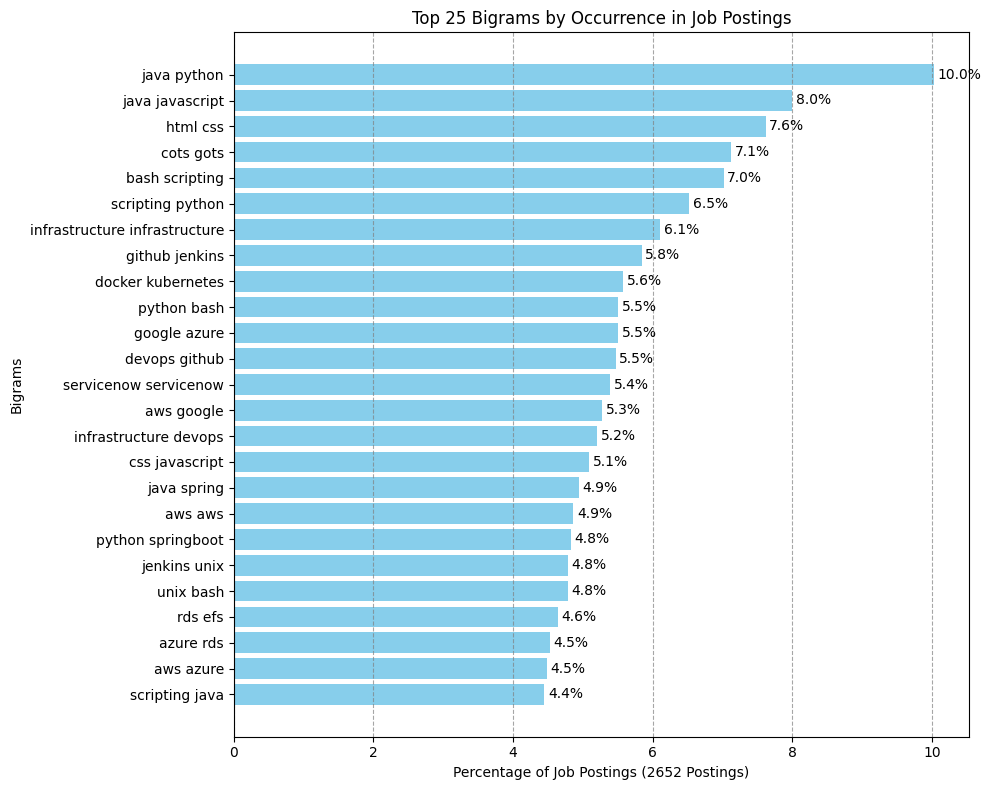

Total job postings count: 2652
Top 150 Bigrams (Bigram - Percentage of Job Postings Bigram is Mentioned):
java python - 10.03%
java javascript - 7.99%
html css - 7.62%
cots gots - 7.13%
bash scripting - 7.01%
scripting python - 6.52%
infrastructure infrastructure - 6.11%
github jenkins - 5.84%
docker kubernetes - 5.58%
python bash - 5.51%
google azure - 5.51%
devops github - 5.47%
servicenow servicenow - 5.39%
aws google - 5.28%
infrastructure devops - 5.20%
css javascript - 5.09%
java spring - 4.94%
aws aws - 4.86%
python springboot - 4.83%
jenkins unix - 4.79%
unix bash - 4.79%
rds efs - 4.64%
azure rds - 4.52%
aws azure - 4.49%
scripting java - 4.45%
junit katalon - 4.34%
katalon infrastructure - 4.34%
bash aws - 4.22%
phantom virtualization - 4.19%
excel phantom - 4.19%
cisco google - 4.19%
virtualization cisco - 4.19%
analytics cots - 4.11%
javascript python - 4.00%
java java - 3.66%
python java - 3.54%
junit scripting - 3.51%
shell scripting - 3.47%
devops junit - 3.47%
devops de

In [308]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType, ArrayType
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams

# Initialize Spark Session
spark = SparkSession.builder.appName("JobDescriptions").getOrCreate()

# Load NLTK stop words and define custom stop words
nltk_stop_words = set(stopwords.words('english'))
custom_stop_words = {'follows', 'iterative', 'builds', 'itil', 'rules', 'innovating', 'stop', 'invest', 'personally', 'unleash','example', 'commands', 'worked', 'logical', 'decomposition', 'aware', 'sw', 'involving', 'according', 'settle', 'adhere','recruitment', 'brings', 'happiness', 'closure', 'eighteen', 'issued', 'electronics', 'accepts', 'telecommute', 'shortened', 'represent','apps', 'ambiguity', 'interactive', 'departments', 'differentiator', 'script', 'commonly', 'condition', 'answer', 'proper', 'unlimited', 'defend','b', 'referrer', 'packed', 'kernel', 'legally', 'yrs', 'accuracy', 'laurel', 'esop', 'acceptable', 'detection', 'formally','bethesda', 'mechanical', 'addressing', 'assessing', 'workloads', 'doctorate', 'survey', 'increase', 'larger', 'regularly', 'campaign', 'alternate','brief', 'demonstrable', 'goal', 'depends', 'bugs', 'encourages', 'pushed', 'prized', 'modification', 'peer', 'realizing', 'tysons', 'incorporated','enthusiasm', 'district', 'save', 'nuclear', 'foundry', 'redirected', 'strength', 'unfaltering', 'abroad', 'vigilant', 'factory', 'president', 'vibrant', 'mapping', 'handle','breadth', 'dissemination', 'sp', 'eap', 'roadmaps', 'achieving', 'restricted', 'sponsored', 'veterans', 'side', 'optimizing', 'translating', 'authority', 'associates', 'screening','advancing', 'prohibits', 'fundamental', 'transitioned', 'info', 'became', 'brought', 'sum', 'vice', 'prodigy', 'waiting', 'placed', 'approached', 'thanks', 'recertification', 'releases', 'homeland','hold', 'streaming', 'deeply', 'chemistry', 'clean', 'embark', 'teleworking', 'transport', 'administer', 'cause', 'logistics', 'advantage', 'upcoming', 'differences', 'extra', 'designated', 'logging','inventive', 'insatiable', 'stealth', 'cognitive', 'atlantic', 'bombers', 'sccm', 'offensive', 'unproven', 'subversion', 'comply', 'ad', 'w', 'zero', 'itsm', 'joint', 'micro', 'seek', 'preparing','audiences', 'regulations', 'thing', 'sign', 'largest', 'facilities', 'hawaii', 'freedom', 'altamira', 'covid','hair', 'ocean', 'emphasizes', 'managed', 'degrees', 'accept', 'routine', 'examples', 'might', 'demands', 'math','true', 'pass', 'speed', 'participant', 'train', 'cryptographic', 'knowledgeable', 'e', 'scholar', 'necessity', 'territory', 'semiconductor','shield', 'layer', 'bar', 'powerpoint', 'updated', 'leaders', 'media', 'accomplish', 'coordinates', 'advice', 'tactical', 'image','desk', 'cares', 'substitute', 'adobe', 'vested', 'twelve', 'opentext', 'classification', 'dhcp', 'baselines', 'shorten', 'previously', 'intelligent', 'moon','mtsi', 'funded', 'affected', 'prospective', 'anticipating', 'recall', 'referred', 'carefirst', 'meets', 'greatest', 'filled', 'transitioning', 'technicians', 'given', 'earth','impossible', 'prohibited', 'formed', 'unwavering', 'landing', 'leaves', 'intellectual', 'connectivity', 'allocate', 'ensures', 'instructions', 'manages', 'depend', 'solves', 'upgrading', 'art', 'interview','collaborates', 'giving', 'credentials', 'social', 'subcontractor', 'submit', 'give', 'upskilling', 'wait','ce', 'warfighter', 'generations', 'perfect', 'acquired', 'thank', 'mentality', 'revolutionary', 'expand', 'compatibility', 'points','evaluates', 'mid', 'engagement', 'ppo', 'insight', 'recovery', 'unless', 'wbs', 'little', 'distribution', 'segment','easy', 'event', 'researches', 'internals', 'uniformed', 'york', 'assured', 'cca', 'actionable', 'mitigation', 'utility', 'measurement','firms', 'ops', 'researching', 'threshold', 'periodically', 'divergent', 'unrivaled', 'certain', 'interaction', 'director', 'implements', 'payments', 'combat','ngmc', 'starts', 'prides', 'thorough', 'weekly', 'vendors', 'briefing', 'presentations', 'ia', 'standalone', 'reusable', 'designers', 'recharge', 'commensurate','preferably', 'enabling', 'aim', 'northern', 'assignments', 'duty', 'hat', 'running', 'providers', 'advise', 'demanding', 'closing', 'acknowledges', 'happens', 'encompass','resumes', 'happy', 'ai', 'eager', 'knowing', 'modernize', 'unified', 'completeness', 'behind', 'ctc', 'id', 'xcelerate', 'recognize', 'tomorrow', 'expectations', 'lean', 'provisioning', 'architects','name', 'challenged', 'mentor', 'cj', 'curiosity', 'incorporate', 'proactive', 'voice','vital', 'specifically', 'comparable', 'thinking', 'discounted', 'quantum', 'layoff', 'yes', 'increases', 'visionist','annualized', 'energy', 'periods', 'connection', 'parkway', 'whose', 'conjunction', 'sustain', 'types', 'teammates', 'acceptance','innovate', 'markets', 'realizable', 'governance', 'passwords', 'earn', 'participates', 'frequently', 'preliminary', 'involves', 'ever','measures', 'overcome', 'accommodate', 'supply', 'inferred', 'unambiguous', 'bdd', 'invent', 'fearlessly', 'seconds', 'administrative','resides', 'decades', 'considering', 'eoe', 'unparalleled', 'extend', 'verified', 'internally', 'ease', 'wireless', 'check', 'executive','word', 'stacks', 'collaboratively', 'logically', 'sessions', 'files', 'connect', 'play', 'modifies', 'absence', 'apart', 'conmd', 'scaled','perks', 'sensitive', 'costs', 'seamless', 'deadlines', 'greater', 'relies', 'discovery', 'involved', 'material', 'responsive', 'findings', 'req','wartime', 'initiative', 'records', 'phone', 'civil', 'imp', 'specialists', 'flight', 'paced', 'cluster', 'single', 'innovations', 'mechanism','positive', 'citizens', 'entity', 'foundation', 'rmf', 'interacting', 'california', 'yet', 'completion', 'timeline', 'condensed', 'character', 'bluehalo', 'ambitions','short', 'practical', 'month', 'firm', 'relentless', 'creativity', 'deadline', 'accountability', 'equitable', 'fsp', 'visible', 'visiting', 'lengthy', 'programmatic', 'human','empowers', 'call', 'estimated', 'sounds', 'ownership', 'continuously', 'especially', 'hard', 'behavior', 'interests', 'mda', 'regardless', 'gaps', 'choice', 'pursue','faith', 'modifying', 'previous', 'practice', 'gaining', 'colorado', 'implemented', 'presenting', 'difficult', 'insights', 'format', 'resolving', 'confidentiality', 'challenge', 'verifiable', 'bold','dev', 'device', 'scenarios', 'placement', 'comptia', 'controls', 'dependencies', 'link', 'courage', 'feels', 'response', 'generating', 'possibly', 'exchange', 'specializing', 'thrives', 'ahead', 'toward', 'harassment',
'cs', 'determining', 'push', 'statements', 'hires', 'analyses', 'case', 'approve', 'blue','termination', 'jovian', 'navstar', 'reading', 'iii', 'exploitation', 'endless', 'fall', 'harnessing','query', 'continue', 'gathering', 'communicating', 'exposure', 'back', 'interactions', 'earned', 'massive', 'manner', 'openings','list', 'trade', 'official', 'adoption', 'issue', 'self', 'notice', 'advancements', 'customize', 'enabled', 'another','taking', 'routing', 'map', 'even', 'milestones', 'messaging', 'due', 'compute', 'breakdown', 'backgrounds', 'subsystem','partnership', 'think', 'tradecraft', 'chn', 'synergy', 'limitless', 'foster', 'recent', 'exploit', 'artificial', 'prioritizes', 'determination','offered', 'migration', 'radio', 'retention', 'knows', 'countries', 'elicitation', 'ultimate', 'immediately', 'engage', 'failure', 'prototypes', 'amounts', 'last','reference', 'searching', 'made', 'study', 'supervision', 'mclean', 'ii', 'monthly', 'explore', 'succeed', 'install', 'let', 'websites', 'sectors','containers', 'setting', 'disposal', 'lactation', 'te', 'technological', 'reach', 'answers', 'configurations', 'dataflow', 'serving', 'chart', 'gather', 'threat','awareness', 'cap', 'amazing', 'rewarding', 'developmental', 'perspectives', 'analyst', 'incredible', 'utilization', 'assisting', 'shown', 'linthicum', 'electronic', 'civilian', 'amount', 'timely','technically', 'usability', 'rapidly', 'incorporates', 'accrue', 'report', 'contributing', 'nefits', 'already', 'architecting', 'vendor', 'entire', 'backup', 'rather', 'tuning', 'fort','subsidized', 'starting', 'allowance', 'enhancing', 'driving', 'genetics', 'containerized', 'sections', 'changing', 'course', 'projected', 'sound', 'discover', 'premium', 'cross', 'usa','families', 'cutting', 'bridge', 'stories', 'heavily', 'interesting', 'align', 'demonstration', 'automating', 'uses', 'advisor', 'selection', 'percentage', 'profit', 'vaccination', 'ecp','whole', 'followed', 'aligning', 'oversight', 'importance', 'applied', 'contingent', 'superior', 'accrued', 'hii', 'formulating', 'comfortable', 'command', 'protocol', 'advises', 'dulles','host', 'incentive', 'guidelines', 'bi', 'desire', 'outcomes', 'elements', 'satisfaction', 'recently', 'huge', 'extended', 'persons', 'ways', 'transform', 'childbirth', 'privacy','maintainability', 'nature', 'things', 'impacts', 'ranges', 'load', 'soap', 'fun', 'conops', 'mentorship', 'oral', 'performs', 'evaluating', 'legal', 'continued', 'fortune', 'formats', 'tailored', 'representative', 'traceability','reality', 'numerous', 'object', 'logic', 'error', 'emphasis', 'premiums', 'materials', 'international', 'expected', 'affordability', 'got', 'highest', 'educational', 'fast', 'installing', 'identified', 'holiday', 'scientists', 'something','desktop', 'briefings', 'displayed', 'ts', 'resiliency', 'deployed', 'participating', 'employs', 'intended', 'boeing','box', 'federally', 'approximately', 'defining', 'studio', 'accurate', 'consistently', 'named', 'promotion', 'demand','continually', 'subsystems', 'ci', 'break', 'ccb', 'container', 'compatible', 'leader', 'supportive', 'cornerstone', 'respect','professionally', 'validate', 'internet', 'creation', 'structures', 'contractual', 'feedback', 'iat', 'mechanisms', 'presentation', 'satisfies','matching', 'real', 'assists', 'nontraditional', 'farthest', 'financing', 'galaxy', 'post', 'union', 'advancement', 'read','truly', 'intern', 'characteristics', 'careers', 'attractive', 'hands', 'sites', 'point', 'inclusivity', 'collective', 'differentiated', 'among','likely', 'fulfill', 'confident', 'celebrate', 'towards', 'minimal', 'content', 'empower', 'allocated', 'fulfills', 'live', 'forward', 'teamwork','private', 'environmental', 'guaranteed', 'pioneering', 'assigned', 'managers', 'either', 'scalability', 'means', 'contractors', 'evolving', 'describe', 'colleagues','red', 'structured', 'fertility', 'boundaries', 'deployments', 'aerospace', 'progress', 'modules', 'prototyping', 'vary', 'impactful', 'consistent', 'special','rapid', 'efficiently', 'directory', 'accessibility', 'video', 'simulation', 'chance', 'encouraged', 'sure', 'sca', 'sea', 'functioning', 'tackle','toughest', 'option', 'timing', 'sr', 'visual', 'resume', 'dc', 'transformative', 'retaining', 'spirit', 'approved', 'continuing', 'loan', 'flows','remotely', 'submissions', 'orchestration', 'assessments', 'readiness', 'vulnerabilities', 'extract', 'tasking', 'forefront', 'capable', 'jobs', 'sprint', 'tech', 'award','budgets', 'interfacing', 'updating', 'line', 'markon', 'feasibility', 'move', 'allow', 'prepare', 'clearly', 'safer', 'establishing', 'strict', 'pride', 'continues', 'disabled', 'incentives','mix', 'shared', 'reduce', 'never', 'telework', 'operates', 'accepted', 'transparency', 'implied','effort', 'update', 'less', 'takes', 'hsa', 'ged', 'treatment', 'sponsorships', 'affirmative', 'disciplines','friend', 'makeup', 'vanguard', 'uhc', 'featuring', 'inux', 'cbtnuggets', 'vsp', 'enterprises', 'become','student', 'willing', 'motivated', 'mobility', 'influence', 'fields', 'execute', 'ltd', 'academy', 'concordia','optimization', 'reflected', 'holders', 'dollars', 'specialized', 'posted', 'enhanced', 'much', 'tware', 'land', 'coworker', 'promote','matched', 'capacity', 'located', 'metrics', 'consider', 'tier', 'fs', 'daunting', 'ethnicity', 'offices', 'force', 'communicates','drives', 'branch', 'sof', 'max', 'store', 'llc', 'division', 'love', 'improvements', 'meaningful', 'since', 'rates','home', 'creative', 'coordinating', 'clusters', 'signature', 'optimum', 'actively', 'generation', 'scheduling', 'proactively', 'patterns', 'fair','worldwide', 'months', 'release', 'air', 'twenty', 'l', 'discrimination', 'reporting', 'eight', 'mobile', 'signals', 'creed', 'sustainment', 'directing','stay', 'workflow', 'click', 'budget', 'alongside', 'relocation', 'mitre', 'junior', 'fulfilling', 'file', 'smarter', 'putting', 'parsons', 'subsidiary', 'authorization','board', 'transfer', 'quicker', 'expect', 'labs', 'quickly', 'risks', 'feel', 'sources', 'interacts', 'accommodations', 'cleared', 'covered', 'imagine', 'overseers', 'accessible', 'path','soa', 'choices', 'though', 'spanning', 'translate', 'produce', 'discriminate','satellite', 'early', 'reward', 'facing', 'requests', 'strive', 'locations', 'empowering', 'interact', 'upgrade','automate', 'libraries', 'trends', 'cost', 'function', 'accreditation', 'diploma', 'oriented', 'wage', 'request', 'collaborating','act', 'array', 'keeping', 'interpersonal', 'microelectronics', 'gitflow', 'events', 'recognized', 'os', 'seta', 'cohesion', 'assets', 'identifying','experiences', 'story', 'contact', 'typically', 'constructs', 'optimal', 'categories', 'tempo', 'window', 'saic', 'configuring', 'scale', 'present','serves', 'opening', 'focuses', 'accounts', 'outcome', 'integrator', 'reston', 'purpose', 'gain', 'derived', 'established', 'attention', 'follow', 'darkstar', 'generate', 'protection','target', 'administrator', 'matters', 'executives', 'interested', 'via', 'reaches', 'refer', 'disabilities', 'armed', 'completed', 'ancestry', 'consequence', 'fill', 'sector', 'prioritize', 'physics','rewards', 'hybrid', 'sick', 'capture', 'autonomy', 'bonuses', 'healthy', 'co','willingness', 'signal', 'fourteen', 'select', 'owned', 'arcfield', 'rate', 'solid', 'sme','long', 'columbia', 'inclusion', 'discretionary', 'depending', 'strategy', 'difference', 'uc', 'requiring','architectural', 'portfolio', 'authentication', 'independent', 'transition', 'limitations', 'strategies', 'associate', 'passion','domain', 'detail', 'investigate', 'built', 'meade', 'facilitate', 'additionally', 'voluntary', 'dependents','boot', 'phases', 'criteria', 'documenting', 'cyberspace', 'manufacturing', 'estimation', 'consequences', 'analytical', 'conducting','someone', 'conducts', 'successfully', 'contracting', 'trust', 'roles', 'diagrams', 'journey', 'globe', 'interest', 'establish','modernization', 'companies', 'traditional', 'decision', 'lasting', 'nexus', 'determined', 'awards', 'noblis', 'always', 'baseline', 'forms','hr', 'cm', 'flex', 'reviewing', 'country', 'nice', 'applying', 'allies', 'shift', 'mental', 'systolic', 'met','sharing', 'done', 'configure', 'guide', 'currently', 'transformation', 'earlier', 'estimate', 'conflicts', 'mathematical', 'everything', 'none','makes', 'courses', 'formal', 'expense', 'measure', 'reliable', 'growing', 'structure', 'exceed', 'resolves', 'bringing', 'recognition','manager', 'enjoy', 'predict', 'competencies', 'analyzes', 'reflects', 'owners', 'spending', 'laws', 'questions', 'believe', 'bargaining','joining', 'reasonably', 'overhead', 'maximum', 'oversee', 'latest', 'utilizes', 'right', 'actions', 'hire', 'consultants', 'cybercore', 'proof','anticipated', 'priority', 'assess', 'devices', 'see', 'hibernate', 'scalable', 'hired', 'investment', 'electrical', 'prime', 'offering', 'statement', 'alternatives','beyond', 'purchase', 'topics', 'considers', 'mathematics','synthesis', 'safety', 'items', 'front', 'enhances', 'studies', 'choose','fit', 'domains', 'preparation', 'determine', 'terms', 'challenging', 'investigation', 'power', 'vesting','allocation', 'utilize', 'edge', 'collection', 'errors', 'direction', 'talent', 'extensive', 'low','enable', 'reliability', 'efficiency', 'applicant', 'shape', 'effective', 'optimize', 'term', 'sci','outside', 'improvement', 'recommend', 'headquartered', 'accenture', 'approach', 'directly', 'history', 'fostering', 'founded', 'record','bachelors', 'usd', 'vulnerability', 'website', 'guides', 'classified', 'school', 'usage', 'public', 'alternative', 'methodology', 'period', 'debugging','priorities', 'novel', 'ten', 'share', 'center', 'task', 'could', 'ca', 'higher', 'six', 'meeting', 'relationships', 'eligibility', 'communities','encourage', 'evaluate', 'delivers', 'objectives', 'algorithm', 'virginia', 'daily', 'optional', 'bs', 'operation', 'serco', 'forces', 'sense', 'order', 'stakeholder','address', 'leads', 'ready', 'excellence', 'department', 'typical', 'dedication','accordance', 'several', 'individually', 'whether', 'anticipates', 'necessary', 'demonstrate', 'remain', 'combination','dependent', 'legacy', 'adapt', 'offerings', 'initial', 'define', 'achieve', 'valued', 'passionate', 'meetings', 'number','view', 'cases', 'external', 'artifacts', 'defects', 'corporate', 'sigint', 'coordination', 'resolution', 'enhancement', 'agency', 'facility','enhancements', 'applies', 'reflect', 'immediate', 'installation', 'allowing', 'ideas', 'contributions', 'machine', 'come', 'details', 'savings', 'packages', 'analysts', 'upgrades', 'want','architect', 'accommodation', 'reasonable', 'deep', 'functionality', 'confer', 'recruiting', 'exciting', 'corporation', 'approval', 'resolve', 'workflows', 'manipulation', 'summary', 'reuse', 'thrive','maintains', 'look', 'scientific', 'consulting', 'remote', 'emerging', 'robust','definition', 'workforce', 'others', 'proficient', 'availability', 'generous', 'add', 'email', 'documented','final', 'reverse', 'troubleshoot', 'executing', 'maximize', 'genetic', 'helping', 'inclusive', 'language','regular', 'annually', 'washington', 'prototype', 'u', 'enhance', 'repositories', 'lieu', 'simple','partner', 'proud', 'herndon', 'goals', 'many', 'form', 'overall', 'equipment', 'search', 'repository','represents', 'execution', 'conditions', 'certified', 'advance', 'ongoing', 'coverage', 'versed', 'decisions', 'defined', 'familiar','northrop', 'principal', 'supported', 'start', 'solving', 'strategic', 'background', 'chantilly', 'provider', 'stock', 'broad','regarding', 'verification', 'policies', 'wellness', 'conduct', 'selected', 'detailed', 'queries', 'two', 'constraints', 'modified', 'identification', 'ground', 'grumman','deploying', 'stem', 'effectiveness', 'base', 'lives', 'assurance', 'extremely', 'marital', 'wide', 'good', 'along', 'possible', 'experts', 'significant', 'skill','integrating', 'guarantee', 'set', 'great', 'assessment', 'around', 'get','geographic', 'atlassian', 'approaches', 'validation', 'virtual', 'page', 'staff', 'operate','storage', 'seven', 'phd', 'initiatives', 'gdit', 'efficient', 'close', 'nightwing','threats', 'ideal', 'ic', 'bring', 'resources', 'making', 'monitor', 'however','balance', 'financial', 'verbal', 'component', 'proven', 'exceptional', 'aspects', 'rtx','week', 'amazon', 'analytic', 'arsiem', 'debug', 'know', 'networks', 'communications', 'comp','global', 'duties', 'intel', 'designed', 'particular', 'includes', 'vacation', 'groups', 'performed','adherence', 'three', 'healthcare', 'better', 'weeks', 'physical', 'k', 'standard', 'resource','skilled', 'independently', 'keep', 'office', 'onsite', 'source', 'organizational', 'outstanding', 'focused', 'addition','considerations', 'booz', 'allen', 'maryland', 'analyzing', 'collaborative', 'basis', 'next', 'guidance', 'equity','guideline', 'pregnancy', 'hiring', 'class', 'updates', 'citizen', 'protect', 'salaries', 'input', 'proposed','supports', 'abilities', 'write', 'trusted', 'contractor', 'throughout', 'obtain', 'military', 'listed', 'masters','potential', 'agreement', 'characteristic', 'talented', 'scrum', 'custom', 'person', 'proficiency', 'america', 'original', 'major','martin', 'omaha', 'utilizing', 'integrated', 'driven', 'overview', 'capability', 'together', 'essential', 'visit', 'version','market', 'free', 'evaluation', 'workplace', 'levels', 'equivalent', 'parental', 'matter', 'ex', 'organizations', 'changes', 'lockheed','managing', 'requisition', 'primary', 'title', 'way', 'grow','family', 'provided', 'mutual', 'alignment', 'secret', 'https', 'dedicated', 'tests','responsibility', 'dynamic', 'today', 'dod', 'account', 'offers', 'important', 'sets','member', 'writing', 'modern', 'five', 'methods', 'networking', 'fully', 'different','first', 'concept', 'tracking', 'reimbursement', 'coding', 'diversity', 'acquisition', 'deliverables','model', 'se', 'contribution', 'positions', 'risk', 'experienced', 'professionals', 'features','successful', 'require', 'extending', 'compliance', 'note', 'solve', 'deploy', 'big','direct', 'tool', 'efforts', 'models', 'functions', 'expression', 'delivery', 'server','algorithms', 'travel', 'reports', 'digital', 'category', 'requirement', 'monitoring', 'ensuring','partners', 'local', 'labor', 'leveraging', 'stakeholders', 'values', 'common', 'improving', 'open','annapolis', 'junction', 'suite', 'correct', 'effectively', 'techniques', 'cycle', 'works', 'match', 'personnel','microsoft', 'contribute', 'solution', 'schedules', 'find', 'value', 'agencies', 'eeo', 'tasks', 'delivering','schedule', 'understand', 'designing', 'administration', 'creating', 'take', 'flexibility', 'unit', 'principles', 'performing', 'computing', 'organization','automated', 'drive', 'collaborate', 'communicate', 'track', 'certifications', 'production', 'derive', 'troubleshooting', 'state', 'secure', 'closely','serve', 'leadership', 'total', 'day', 'confluence', 'end', 'frameworks', 'site', 'would', 'mandatory', 'implementing', 'flow','states', 'improve', 'annual', 'allows', 'challenges', 'recommendations', 'used', 'personal', 'integrity', 'online', 'developed', 'citizenship', 'collaboration','document', 'unique', 'small', 'research', 'excellent', 'able','posting', 'applicable', 'also', 'options', 'change', 'candidates', 'written','develops', 'referral', 'group', 'interfaces', 'prior', 'continuous', 'four', 'safe', 'maintaining', 'complete','individuals', 'benefit', 'area', 'platform', 'platforms', 'responsible', 'needed', 'stack', 'internal', 'results','focus', 'databases', 'leverage', 'core', 'designs', 'windows', 'tuition', 'peraton', 'shall', 'integrate','general', 'jira', 'variety', 'manage', 'developers', 'subject', 'sponsor', 'upon', 'modify', 'future','space', 'expert', 'success', 'users', 'swe', 'law', 'functional', 'automation', 'building', 'innovation','committed', 'associated', 'members', 'methodologies', 'retirement', 'complexity', 'eligible', 'commitment', 'identify', 'appropriate','package', 'coordinate', 'bonus', 'least', 'leidos', 'problem', 'possess', 'lead', 'concepts', 'various','competitive', 'dental', 'processing', 'certification', 'united', 'basic', 'architectures', 'specifications', 'available', 'learning','advanced', 'framework', 'caci', 'assistance', 'quality', 'place', 'senior', 'pto', 'care', 'substituted','please', 'key', 'dcca', 'current', 'specific', 'md', 'communication', 'access', 'comprehensive', 'contracts','university', 'leave', 'every', 'world', 'innovative', 'documents', 'medical', 'impact', 'per', 'familiarity','va', 'review', 'action', 'industry', 'contract', 'assist', 'college', 'policy', 'languages', 'hours','procedures', 'age', 'leading', 'preferred', 'accredited', 'holidays', 'master', 'maintenance', 'clients', 'culture', 'planning','issues', 'nation', 'areas', 'top', 'need', 'etc', 'missions', 'implementation', 'learn', 'reviews', 'large', 'plus','community', 'consideration', 'operational', 'date', 'cyber', 'poly', 'diverse', 'minimum', 'client', 'days', 'deliver', 'flexible', 'product','commercial', 'deployment', 'lifecycle', 'participate', 'operating', 'field', 'service', 'people', 'create', 'considered', 'interface', 'highly', 'factors','problems', 'regard', 'growth', 'configuration', 'sex', 'requires', 'individual', 'analyze', 'limited', 'following', 'supporting', 'vision', 'make','high', 'defense', 'desired', 'network', 'offer', 'seeking', 'products', 'like', 'expertise', 'help', 'health', 'multiple', 'looking', 'programming','similar', 'providing', 'plans', 'professional', 'provides', 'orientation', 'sexual', 'critical', 'maintain', 'hardware', 'type', 'perform', 'understanding', 'part', 'build','discipline', 'activities', 'federal', 'religion', 'color', 'implement','code', 'enterprise', 'identity', 'gender', 'projects', 'meet','use', 'race', 'qualified', 'training', 'join', 'origin','one', 'engineers', 'scope', 'without', 'description', 'location', 'protected','components', 'environments', 'additional', 'practices', 'teams', 'standards', 'veteran','strong', 'career', 'control', 'best', 'applicants', 'receive', 'relevant','customers', 'operations', 'insurance', 'full', 'programs', 'education', 'across', 'user','life', 'employee', 'developer', 'employer', 'pay', 'architecture', 'web', 'equal','documentation', 'existing', 'role', 'responsibilities', 'opportunities', 'processes', 'plan', 'capabilities', 'within','project', 'compensation', 'active', 'opportunity', 'complex', 'based', 'needs', 'intelligence', 'well','test', 'employment', 'application', 'testing', 'paid', 'include', 'integration', 'science', 'agile', 'developing', 'may', 'process', 'computer', 'us', 'analysis', 'candidate', 'technology', 'ensure','qualifications', 'business', 'bachelor', 'disability', 'time', 'status', 'knowledge', 'working', 'national', 'ability','cloud', 'tools', 'must', 'technologies', 'applications', 'level', 'related', 'polygraph', 'performance', 'range','customer', 'including', 'information', 'program', 'demonstrated', 'mission', 'company', 'provide', 'salary', 'government','solutions', 'degree', 'skills', 'management', 'benefits', 'employees', 'new', 'develop', 'engineer', 'services','software', 'development', 'systems', 'work', 'engineering', 'support', 'team', 'design', 'data', 'technical','system', 'requirements', 'this', 'required', 'position', 'security', 'using', 'clearance', 'environment','system', 'requirements', 'job', 'position', 'apply', 'experience', 'required', 'year', 'years'}

all_stop_words = nltk_stop_words.union(custom_stop_words)

# Broadcast the stop words to all workers
broadcast_stop_words = spark.sparkContext.broadcast(all_stop_words)

# Connect to SQLite and load data into Pandas DataFrame
conn = sqlite3.connect('jobs.db')
job_descriptions_df = pd.read_sql_query("SELECT description FROM jobs", conn)
conn.close()

# Get the total number of job descriptions
total_job_descriptions = len(job_descriptions_df)

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(job_descriptions_df)

# Define UDF for tokenizing, filtering stop words, and creating bigrams
def tokenize_filter_bigrams(text):
    tokens = word_tokenize(text)
    stop_words = broadcast_stop_words.value
    # Filter out stop words and keep only alphabetical tokens
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    # Generate bigrams from the filtered tokens
    bigrams_list = [' '.join(bigram) for bigram in bigrams(filtered_tokens)]
    return bigrams_list

# Register the UDF with Spark
tokenize_filter_bigrams_udf = udf(tokenize_filter_bigrams, ArrayType(StringType()))

# Apply tokenization, filtering, and bigram generation
filtered_bigrams_df = spark_df.withColumn("filtered_bigrams", tokenize_filter_bigrams_udf(col("description")))

# Explode the bigrams for frequency count
exploded_bigrams_df = filtered_bigrams_df.withColumn("bigram", explode(col("filtered_bigrams")))

# Count bigram frequencies
bigram_counts = exploded_bigrams_df.groupBy("bigram").count().orderBy(col("count").desc())

# Get the top 150 bigrams
top_bigrams = bigram_counts.limit(150).collect()

# Prepare data for plotting
bigrams_list = [row['bigram'] for row in top_bigrams]
percentages = [(row['count'] / total_job_descriptions) * 100 for row in top_bigrams]
show_on_plot = 25  # Show top 25 in the plot

# Plot the data using matplotlib
plt.figure(figsize=(10, 8))
bars = plt.barh(bigrams_list[:show_on_plot][::-1], percentages[:show_on_plot][::-1], color='skyblue')  # Reverse lists to have the highest at the top
plt.xlabel(f'Percentage of Job Postings ({total_job_descriptions} Postings)')
plt.ylabel('Bigrams')
plt.title(f'Top {show_on_plot} Bigrams by Occurrence in Job Postings')
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

# Add percentage labels at the end of each bar
for bar, percentage in zip(bars, percentages[:show_on_plot][::-1]):
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"Total job postings count: {total_job_descriptions}")
print("Top 150 Bigrams (Bigram - Percentage of Job Postings Bigram is Mentioned):")

for row in top_bigrams:
    percentage = (row['count'] / total_job_descriptions) * 100
    print(f"{row['bigram']} - {percentage:.2f}%")

# Stop the Spark session
spark.stop()


Trigrams

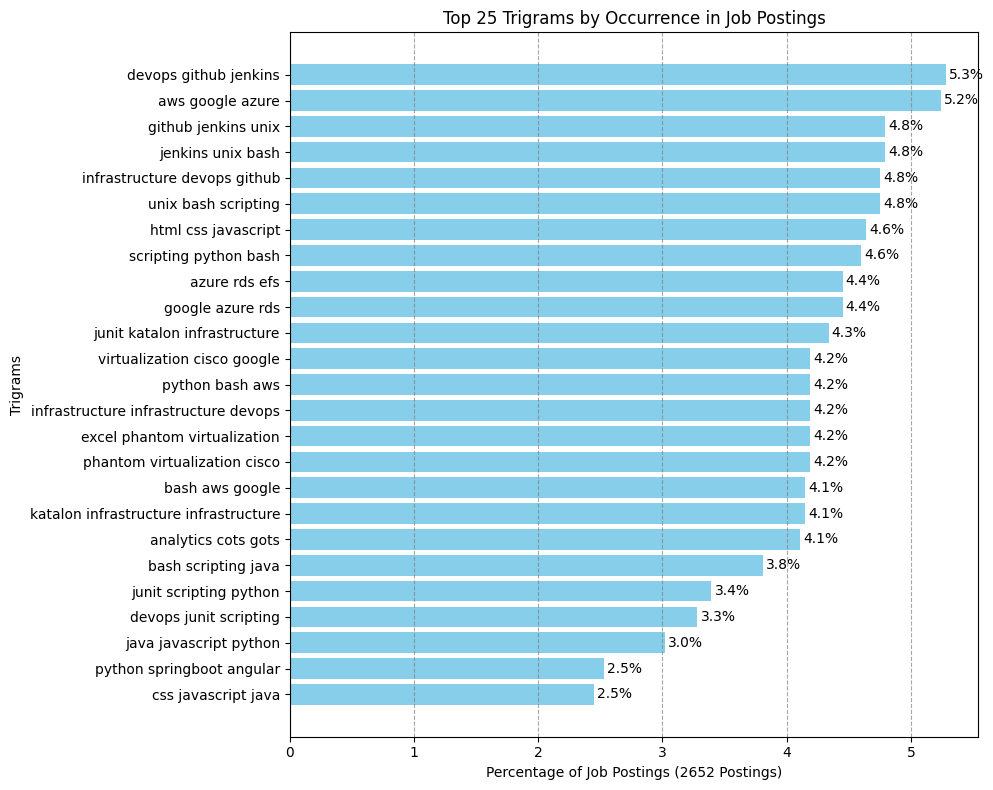

Total job postings count: 2652
Top 150 Trigrams (Trigram - Percentage of Job Postings Trigram is Mentioned):
devops github jenkins - 5.28%
aws google azure - 5.24%
github jenkins unix - 4.79%
jenkins unix bash - 4.79%
infrastructure devops github - 4.75%
unix bash scripting - 4.75%
html css javascript - 4.64%
scripting python bash - 4.60%
azure rds efs - 4.45%
google azure rds - 4.45%
junit katalon infrastructure - 4.34%
virtualization cisco google - 4.19%
python bash aws - 4.19%
infrastructure infrastructure devops - 4.19%
excel phantom virtualization - 4.19%
phantom virtualization cisco - 4.19%
bash aws google - 4.15%
katalon infrastructure infrastructure - 4.15%
analytics cots gots - 4.11%
bash scripting java - 3.81%
junit scripting python - 3.39%
devops junit scripting - 3.28%
java javascript python - 3.02%
python springboot angular - 2.53%
css javascript java - 2.45%
angular junit katalon - 2.45%
springboot angular junit - 2.45%
javascript java python - 2.26%
javascript python spr

In [307]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType, ArrayType
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import trigrams

# Initialize Spark Session
spark = SparkSession.builder.appName("JobDescriptions").getOrCreate()

# Load NLTK stop words and define custom stop words
nltk_stop_words = set(stopwords.words('english'))
custom_stop_words = {'follows', 'iterative', 'builds', 'itil', 'rules', 'innovating', 'stop', 'invest', 'personally', 'unleash','example', 'commands', 'worked', 'logical', 'decomposition', 'aware', 'sw', 'involving', 'according', 'settle', 'adhere','recruitment', 'brings', 'happiness', 'closure', 'eighteen', 'issued', 'electronics', 'accepts', 'telecommute', 'shortened', 'represent','apps', 'ambiguity', 'interactive', 'departments', 'differentiator', 'script', 'commonly', 'condition', 'answer', 'proper', 'unlimited', 'defend','b', 'referrer', 'packed', 'kernel', 'legally', 'yrs', 'accuracy', 'laurel', 'esop', 'acceptable', 'detection', 'formally','bethesda', 'mechanical', 'addressing', 'assessing', 'workloads', 'doctorate', 'survey', 'increase', 'larger', 'regularly', 'campaign', 'alternate','brief', 'demonstrable', 'goal', 'depends', 'bugs', 'encourages', 'pushed', 'prized', 'modification', 'peer', 'realizing', 'tysons', 'incorporated','enthusiasm', 'district', 'save', 'nuclear', 'foundry', 'redirected', 'strength', 'unfaltering', 'abroad', 'vigilant', 'factory', 'president', 'vibrant', 'mapping', 'handle','breadth', 'dissemination', 'sp', 'eap', 'roadmaps', 'achieving', 'restricted', 'sponsored', 'veterans', 'side', 'optimizing', 'translating', 'authority', 'associates', 'screening','advancing', 'prohibits', 'fundamental', 'transitioned', 'info', 'became', 'brought', 'sum', 'vice', 'prodigy', 'waiting', 'placed', 'approached', 'thanks', 'recertification', 'releases', 'homeland','hold', 'streaming', 'deeply', 'chemistry', 'clean', 'embark', 'teleworking', 'transport', 'administer', 'cause', 'logistics', 'advantage', 'upcoming', 'differences', 'extra', 'designated', 'logging','inventive', 'insatiable', 'stealth', 'cognitive', 'atlantic', 'bombers', 'sccm', 'offensive', 'unproven', 'subversion', 'comply', 'ad', 'w', 'zero', 'itsm', 'joint', 'micro', 'seek', 'preparing','audiences', 'regulations', 'thing', 'sign', 'largest', 'facilities', 'hawaii', 'freedom', 'altamira', 'covid','hair', 'ocean', 'emphasizes', 'managed', 'degrees', 'accept', 'routine', 'examples', 'might', 'demands', 'math','true', 'pass', 'speed', 'participant', 'train', 'cryptographic', 'knowledgeable', 'e', 'scholar', 'necessity', 'territory', 'semiconductor','shield', 'layer', 'bar', 'powerpoint', 'updated', 'leaders', 'media', 'accomplish', 'coordinates', 'advice', 'tactical', 'image','desk', 'cares', 'substitute', 'adobe', 'vested', 'twelve', 'opentext', 'classification', 'dhcp', 'baselines', 'shorten', 'previously', 'intelligent', 'moon','mtsi', 'funded', 'affected', 'prospective', 'anticipating', 'recall', 'referred', 'carefirst', 'meets', 'greatest', 'filled', 'transitioning', 'technicians', 'given', 'earth','impossible', 'prohibited', 'formed', 'unwavering', 'landing', 'leaves', 'intellectual', 'connectivity', 'allocate', 'ensures', 'instructions', 'manages', 'depend', 'solves', 'upgrading', 'art', 'interview','collaborates', 'giving', 'credentials', 'social', 'subcontractor', 'submit', 'give', 'upskilling', 'wait','ce', 'warfighter', 'generations', 'perfect', 'acquired', 'thank', 'mentality', 'revolutionary', 'expand', 'compatibility', 'points','evaluates', 'mid', 'engagement', 'ppo', 'insight', 'recovery', 'unless', 'wbs', 'little', 'distribution', 'segment','easy', 'event', 'researches', 'internals', 'uniformed', 'york', 'assured', 'cca', 'actionable', 'mitigation', 'utility', 'measurement','firms', 'ops', 'researching', 'threshold', 'periodically', 'divergent', 'unrivaled', 'certain', 'interaction', 'director', 'implements', 'payments', 'combat','ngmc', 'starts', 'prides', 'thorough', 'weekly', 'vendors', 'briefing', 'presentations', 'ia', 'standalone', 'reusable', 'designers', 'recharge', 'commensurate','preferably', 'enabling', 'aim', 'northern', 'assignments', 'duty', 'hat', 'running', 'providers', 'advise', 'demanding', 'closing', 'acknowledges', 'happens', 'encompass','resumes', 'happy', 'ai', 'eager', 'knowing', 'modernize', 'unified', 'completeness', 'behind', 'ctc', 'id', 'xcelerate', 'recognize', 'tomorrow', 'expectations', 'lean', 'provisioning', 'architects','name', 'challenged', 'mentor', 'cj', 'curiosity', 'incorporate', 'proactive', 'voice','vital', 'specifically', 'comparable', 'thinking', 'discounted', 'quantum', 'layoff', 'yes', 'increases', 'visionist','annualized', 'energy', 'periods', 'connection', 'parkway', 'whose', 'conjunction', 'sustain', 'types', 'teammates', 'acceptance','innovate', 'markets', 'realizable', 'governance', 'passwords', 'earn', 'participates', 'frequently', 'preliminary', 'involves', 'ever','measures', 'overcome', 'accommodate', 'supply', 'inferred', 'unambiguous', 'bdd', 'invent', 'fearlessly', 'seconds', 'administrative','resides', 'decades', 'considering', 'eoe', 'unparalleled', 'extend', 'verified', 'internally', 'ease', 'wireless', 'check', 'executive','word', 'stacks', 'collaboratively', 'logically', 'sessions', 'files', 'connect', 'play', 'modifies', 'absence', 'apart', 'conmd', 'scaled','perks', 'sensitive', 'costs', 'seamless', 'deadlines', 'greater', 'relies', 'discovery', 'involved', 'material', 'responsive', 'findings', 'req','wartime', 'initiative', 'records', 'phone', 'civil', 'imp', 'specialists', 'flight', 'paced', 'cluster', 'single', 'innovations', 'mechanism','positive', 'citizens', 'entity', 'foundation', 'rmf', 'interacting', 'california', 'yet', 'completion', 'timeline', 'condensed', 'character', 'bluehalo', 'ambitions','short', 'practical', 'month', 'firm', 'relentless', 'creativity', 'deadline', 'accountability', 'equitable', 'fsp', 'visible', 'visiting', 'lengthy', 'programmatic', 'human','empowers', 'call', 'estimated', 'sounds', 'ownership', 'continuously', 'especially', 'hard', 'behavior', 'interests', 'mda', 'regardless', 'gaps', 'choice', 'pursue','faith', 'modifying', 'previous', 'practice', 'gaining', 'colorado', 'implemented', 'presenting', 'difficult', 'insights', 'format', 'resolving', 'confidentiality', 'challenge', 'verifiable', 'bold','dev', 'device', 'scenarios', 'placement', 'comptia', 'controls', 'dependencies', 'link', 'courage', 'feels', 'response', 'generating', 'possibly', 'exchange', 'specializing', 'thrives', 'ahead', 'toward', 'harassment',
'cs', 'determining', 'push', 'statements', 'hires', 'analyses', 'case', 'approve', 'blue','termination', 'jovian', 'navstar', 'reading', 'iii', 'exploitation', 'endless', 'fall', 'harnessing','query', 'continue', 'gathering', 'communicating', 'exposure', 'back', 'interactions', 'earned', 'massive', 'manner', 'openings','list', 'trade', 'official', 'adoption', 'issue', 'self', 'notice', 'advancements', 'customize', 'enabled', 'another','taking', 'routing', 'map', 'even', 'milestones', 'messaging', 'due', 'compute', 'breakdown', 'backgrounds', 'subsystem','partnership', 'think', 'tradecraft', 'chn', 'synergy', 'limitless', 'foster', 'recent', 'exploit', 'artificial', 'prioritizes', 'determination','offered', 'migration', 'radio', 'retention', 'knows', 'countries', 'elicitation', 'ultimate', 'immediately', 'engage', 'failure', 'prototypes', 'amounts', 'last','reference', 'searching', 'made', 'study', 'supervision', 'mclean', 'ii', 'monthly', 'explore', 'succeed', 'install', 'let', 'websites', 'sectors','containers', 'setting', 'disposal', 'lactation', 'te', 'technological', 'reach', 'answers', 'configurations', 'dataflow', 'serving', 'chart', 'gather', 'threat','awareness', 'cap', 'amazing', 'rewarding', 'developmental', 'perspectives', 'analyst', 'incredible', 'utilization', 'assisting', 'shown', 'linthicum', 'electronic', 'civilian', 'amount', 'timely','technically', 'usability', 'rapidly', 'incorporates', 'accrue', 'report', 'contributing', 'nefits', 'already', 'architecting', 'vendor', 'entire', 'backup', 'rather', 'tuning', 'fort','subsidized', 'starting', 'allowance', 'enhancing', 'driving', 'genetics', 'containerized', 'sections', 'changing', 'course', 'projected', 'sound', 'discover', 'premium', 'cross', 'usa','families', 'cutting', 'bridge', 'stories', 'heavily', 'interesting', 'align', 'demonstration', 'automating', 'uses', 'advisor', 'selection', 'percentage', 'profit', 'vaccination', 'ecp','whole', 'followed', 'aligning', 'oversight', 'importance', 'applied', 'contingent', 'superior', 'accrued', 'hii', 'formulating', 'comfortable', 'command', 'protocol', 'advises', 'dulles','host', 'incentive', 'guidelines', 'bi', 'desire', 'outcomes', 'elements', 'satisfaction', 'recently', 'huge', 'extended', 'persons', 'ways', 'transform', 'childbirth', 'privacy','maintainability', 'nature', 'things', 'impacts', 'ranges', 'load', 'soap', 'fun', 'conops', 'mentorship', 'oral', 'performs', 'evaluating', 'legal', 'continued', 'fortune', 'formats', 'tailored', 'representative', 'traceability','reality', 'numerous', 'object', 'logic', 'error', 'emphasis', 'premiums', 'materials', 'international', 'expected', 'affordability', 'got', 'highest', 'educational', 'fast', 'installing', 'identified', 'holiday', 'scientists', 'something','desktop', 'briefings', 'displayed', 'ts', 'resiliency', 'deployed', 'participating', 'employs', 'intended', 'boeing','box', 'federally', 'approximately', 'defining', 'studio', 'accurate', 'consistently', 'named', 'promotion', 'demand','continually', 'subsystems', 'ci', 'break', 'ccb', 'container', 'compatible', 'leader', 'supportive', 'cornerstone', 'respect','professionally', 'validate', 'internet', 'creation', 'structures', 'contractual', 'feedback', 'iat', 'mechanisms', 'presentation', 'satisfies','matching', 'real', 'assists', 'nontraditional', 'farthest', 'financing', 'galaxy', 'post', 'union', 'advancement', 'read','truly', 'intern', 'characteristics', 'careers', 'attractive', 'hands', 'sites', 'point', 'inclusivity', 'collective', 'differentiated', 'among','likely', 'fulfill', 'confident', 'celebrate', 'towards', 'minimal', 'content', 'empower', 'allocated', 'fulfills', 'live', 'forward', 'teamwork','private', 'environmental', 'guaranteed', 'pioneering', 'assigned', 'managers', 'either', 'scalability', 'means', 'contractors', 'evolving', 'describe', 'colleagues','red', 'structured', 'fertility', 'boundaries', 'deployments', 'aerospace', 'progress', 'modules', 'prototyping', 'vary', 'impactful', 'consistent', 'special','rapid', 'efficiently', 'directory', 'accessibility', 'video', 'simulation', 'chance', 'encouraged', 'sure', 'sca', 'sea', 'functioning', 'tackle','toughest', 'option', 'timing', 'sr', 'visual', 'resume', 'dc', 'transformative', 'retaining', 'spirit', 'approved', 'continuing', 'loan', 'flows','remotely', 'submissions', 'orchestration', 'assessments', 'readiness', 'vulnerabilities', 'extract', 'tasking', 'forefront', 'capable', 'jobs', 'sprint', 'tech', 'award','budgets', 'interfacing', 'updating', 'line', 'markon', 'feasibility', 'move', 'allow', 'prepare', 'clearly', 'safer', 'establishing', 'strict', 'pride', 'continues', 'disabled', 'incentives','mix', 'shared', 'reduce', 'never', 'telework', 'operates', 'accepted', 'transparency', 'implied','effort', 'update', 'less', 'takes', 'hsa', 'ged', 'treatment', 'sponsorships', 'affirmative', 'disciplines','friend', 'makeup', 'vanguard', 'uhc', 'featuring', 'inux', 'cbtnuggets', 'vsp', 'enterprises', 'become','student', 'willing', 'motivated', 'mobility', 'influence', 'fields', 'execute', 'ltd', 'academy', 'concordia','optimization', 'reflected', 'holders', 'dollars', 'specialized', 'posted', 'enhanced', 'much', 'tware', 'land', 'coworker', 'promote','matched', 'capacity', 'located', 'metrics', 'consider', 'tier', 'fs', 'daunting', 'ethnicity', 'offices', 'force', 'communicates','drives', 'branch', 'sof', 'max', 'store', 'llc', 'division', 'love', 'improvements', 'meaningful', 'since', 'rates','home', 'creative', 'coordinating', 'clusters', 'signature', 'optimum', 'actively', 'generation', 'scheduling', 'proactively', 'patterns', 'fair','worldwide', 'months', 'release', 'air', 'twenty', 'l', 'discrimination', 'reporting', 'eight', 'mobile', 'signals', 'creed', 'sustainment', 'directing','stay', 'workflow', 'click', 'budget', 'alongside', 'relocation', 'mitre', 'junior', 'fulfilling', 'file', 'smarter', 'putting', 'parsons', 'subsidiary', 'authorization','board', 'transfer', 'quicker', 'expect', 'labs', 'quickly', 'risks', 'feel', 'sources', 'interacts', 'accommodations', 'cleared', 'covered', 'imagine', 'overseers', 'accessible', 'path','soa', 'choices', 'though', 'spanning', 'translate', 'produce', 'discriminate','satellite', 'early', 'reward', 'facing', 'requests', 'strive', 'locations', 'empowering', 'interact', 'upgrade','automate', 'libraries', 'trends', 'cost', 'function', 'accreditation', 'diploma', 'oriented', 'wage', 'request', 'collaborating','act', 'array', 'keeping', 'interpersonal', 'microelectronics', 'gitflow', 'events', 'recognized', 'os', 'seta', 'cohesion', 'assets', 'identifying','experiences', 'story', 'contact', 'typically', 'constructs', 'optimal', 'categories', 'tempo', 'window', 'saic', 'configuring', 'scale', 'present','serves', 'opening', 'focuses', 'accounts', 'outcome', 'integrator', 'reston', 'purpose', 'gain', 'derived', 'established', 'attention', 'follow', 'darkstar', 'generate', 'protection','target', 'administrator', 'matters', 'executives', 'interested', 'via', 'reaches', 'refer', 'disabilities', 'armed', 'completed', 'ancestry', 'consequence', 'fill', 'sector', 'prioritize', 'physics','rewards', 'hybrid', 'sick', 'capture', 'autonomy', 'bonuses', 'healthy', 'co','willingness', 'signal', 'fourteen', 'select', 'owned', 'arcfield', 'rate', 'solid', 'sme','long', 'columbia', 'inclusion', 'discretionary', 'depending', 'strategy', 'difference', 'uc', 'requiring','architectural', 'portfolio', 'authentication', 'independent', 'transition', 'limitations', 'strategies', 'associate', 'passion','domain', 'detail', 'investigate', 'built', 'meade', 'facilitate', 'additionally', 'voluntary', 'dependents','boot', 'phases', 'criteria', 'documenting', 'cyberspace', 'manufacturing', 'estimation', 'consequences', 'analytical', 'conducting','someone', 'conducts', 'successfully', 'contracting', 'trust', 'roles', 'diagrams', 'journey', 'globe', 'interest', 'establish','modernization', 'companies', 'traditional', 'decision', 'lasting', 'nexus', 'determined', 'awards', 'noblis', 'always', 'baseline', 'forms','hr', 'cm', 'flex', 'reviewing', 'country', 'nice', 'applying', 'allies', 'shift', 'mental', 'systolic', 'met','sharing', 'done', 'configure', 'guide', 'currently', 'transformation', 'earlier', 'estimate', 'conflicts', 'mathematical', 'everything', 'none','makes', 'courses', 'formal', 'expense', 'measure', 'reliable', 'growing', 'structure', 'exceed', 'resolves', 'bringing', 'recognition','manager', 'enjoy', 'predict', 'competencies', 'analyzes', 'reflects', 'owners', 'spending', 'laws', 'questions', 'believe', 'bargaining','joining', 'reasonably', 'overhead', 'maximum', 'oversee', 'latest', 'utilizes', 'right', 'actions', 'hire', 'consultants', 'cybercore', 'proof','anticipated', 'priority', 'assess', 'devices', 'see', 'hibernate', 'scalable', 'hired', 'investment', 'electrical', 'prime', 'offering', 'statement', 'alternatives','beyond', 'purchase', 'topics', 'considers', 'mathematics','synthesis', 'safety', 'items', 'front', 'enhances', 'studies', 'choose','fit', 'domains', 'preparation', 'determine', 'terms', 'challenging', 'investigation', 'power', 'vesting','allocation', 'utilize', 'edge', 'collection', 'errors', 'direction', 'talent', 'extensive', 'low','enable', 'reliability', 'efficiency', 'applicant', 'shape', 'effective', 'optimize', 'term', 'sci','outside', 'improvement', 'recommend', 'headquartered', 'accenture', 'approach', 'directly', 'history', 'fostering', 'founded', 'record','bachelors', 'usd', 'vulnerability', 'website', 'guides', 'classified', 'school', 'usage', 'public', 'alternative', 'methodology', 'period', 'debugging','priorities', 'novel', 'ten', 'share', 'center', 'task', 'could', 'ca', 'higher', 'six', 'meeting', 'relationships', 'eligibility', 'communities','encourage', 'evaluate', 'delivers', 'objectives', 'algorithm', 'virginia', 'daily', 'optional', 'bs', 'operation', 'serco', 'forces', 'sense', 'order', 'stakeholder','address', 'leads', 'ready', 'excellence', 'department', 'typical', 'dedication','accordance', 'several', 'individually', 'whether', 'anticipates', 'necessary', 'demonstrate', 'remain', 'combination','dependent', 'legacy', 'adapt', 'offerings', 'initial', 'define', 'achieve', 'valued', 'passionate', 'meetings', 'number','view', 'cases', 'external', 'artifacts', 'defects', 'corporate', 'sigint', 'coordination', 'resolution', 'enhancement', 'agency', 'facility','enhancements', 'applies', 'reflect', 'immediate', 'installation', 'allowing', 'ideas', 'contributions', 'machine', 'come', 'details', 'savings', 'packages', 'analysts', 'upgrades', 'want','architect', 'accommodation', 'reasonable', 'deep', 'functionality', 'confer', 'recruiting', 'exciting', 'corporation', 'approval', 'resolve', 'workflows', 'manipulation', 'summary', 'reuse', 'thrive','maintains', 'look', 'scientific', 'consulting', 'remote', 'emerging', 'robust','definition', 'workforce', 'others', 'proficient', 'availability', 'generous', 'add', 'email', 'documented','final', 'reverse', 'troubleshoot', 'executing', 'maximize', 'genetic', 'helping', 'inclusive', 'language','regular', 'annually', 'washington', 'prototype', 'u', 'enhance', 'repositories', 'lieu', 'simple','partner', 'proud', 'herndon', 'goals', 'many', 'form', 'overall', 'equipment', 'search', 'repository','represents', 'execution', 'conditions', 'certified', 'advance', 'ongoing', 'coverage', 'versed', 'decisions', 'defined', 'familiar','northrop', 'principal', 'supported', 'start', 'solving', 'strategic', 'background', 'chantilly', 'provider', 'stock', 'broad','regarding', 'verification', 'policies', 'wellness', 'conduct', 'selected', 'detailed', 'queries', 'two', 'constraints', 'modified', 'identification', 'ground', 'grumman','deploying', 'stem', 'effectiveness', 'base', 'lives', 'assurance', 'extremely', 'marital', 'wide', 'good', 'along', 'possible', 'experts', 'significant', 'skill','integrating', 'guarantee', 'set', 'great', 'assessment', 'around', 'get','geographic', 'atlassian', 'approaches', 'validation', 'virtual', 'page', 'staff', 'operate','storage', 'seven', 'phd', 'initiatives', 'gdit', 'efficient', 'close', 'nightwing','threats', 'ideal', 'ic', 'bring', 'resources', 'making', 'monitor', 'however','balance', 'financial', 'verbal', 'component', 'proven', 'exceptional', 'aspects', 'rtx','week', 'amazon', 'analytic', 'arsiem', 'debug', 'know', 'networks', 'communications', 'comp','global', 'duties', 'intel', 'designed', 'particular', 'includes', 'vacation', 'groups', 'performed','adherence', 'three', 'healthcare', 'better', 'weeks', 'physical', 'k', 'standard', 'resource','skilled', 'independently', 'keep', 'office', 'onsite', 'source', 'organizational', 'outstanding', 'focused', 'addition','considerations', 'booz', 'allen', 'maryland', 'analyzing', 'collaborative', 'basis', 'next', 'guidance', 'equity','guideline', 'pregnancy', 'hiring', 'class', 'updates', 'citizen', 'protect', 'salaries', 'input', 'proposed','supports', 'abilities', 'write', 'trusted', 'contractor', 'throughout', 'obtain', 'military', 'listed', 'masters','potential', 'agreement', 'characteristic', 'talented', 'scrum', 'custom', 'person', 'proficiency', 'america', 'original', 'major','martin', 'omaha', 'utilizing', 'integrated', 'driven', 'overview', 'capability', 'together', 'essential', 'visit', 'version','market', 'free', 'evaluation', 'workplace', 'levels', 'equivalent', 'parental', 'matter', 'ex', 'organizations', 'changes', 'lockheed','managing', 'requisition', 'primary', 'title', 'way', 'grow','family', 'provided', 'mutual', 'alignment', 'secret', 'https', 'dedicated', 'tests','responsibility', 'dynamic', 'today', 'dod', 'account', 'offers', 'important', 'sets','member', 'writing', 'modern', 'five', 'methods', 'networking', 'fully', 'different','first', 'concept', 'tracking', 'reimbursement', 'coding', 'diversity', 'acquisition', 'deliverables','model', 'se', 'contribution', 'positions', 'risk', 'experienced', 'professionals', 'features','successful', 'require', 'extending', 'compliance', 'note', 'solve', 'deploy', 'big','direct', 'tool', 'efforts', 'models', 'functions', 'expression', 'delivery', 'server','algorithms', 'travel', 'reports', 'digital', 'category', 'requirement', 'monitoring', 'ensuring','partners', 'local', 'labor', 'leveraging', 'stakeholders', 'values', 'common', 'improving', 'open','annapolis', 'junction', 'suite', 'correct', 'effectively', 'techniques', 'cycle', 'works', 'match', 'personnel','microsoft', 'contribute', 'solution', 'schedules', 'find', 'value', 'agencies', 'eeo', 'tasks', 'delivering','schedule', 'understand', 'designing', 'administration', 'creating', 'take', 'flexibility', 'unit', 'principles', 'performing', 'computing', 'organization','automated', 'drive', 'collaborate', 'communicate', 'track', 'certifications', 'production', 'derive', 'troubleshooting', 'state', 'secure', 'closely','serve', 'leadership', 'total', 'day', 'confluence', 'end', 'frameworks', 'site', 'would', 'mandatory', 'implementing', 'flow','states', 'improve', 'annual', 'allows', 'challenges', 'recommendations', 'used', 'personal', 'integrity', 'online', 'developed', 'citizenship', 'collaboration','document', 'unique', 'small', 'research', 'excellent', 'able','posting', 'applicable', 'also', 'options', 'change', 'candidates', 'written','develops', 'referral', 'group', 'interfaces', 'prior', 'continuous', 'four', 'safe', 'maintaining', 'complete','individuals', 'benefit', 'area', 'platform', 'platforms', 'responsible', 'needed', 'stack', 'internal', 'results','focus', 'databases', 'leverage', 'core', 'designs', 'windows', 'tuition', 'peraton', 'shall', 'integrate','general', 'jira', 'variety', 'manage', 'developers', 'subject', 'sponsor', 'upon', 'modify', 'future','space', 'expert', 'success', 'users', 'swe', 'law', 'functional', 'automation', 'building', 'innovation','committed', 'associated', 'members', 'methodologies', 'retirement', 'complexity', 'eligible', 'commitment', 'identify', 'appropriate','package', 'coordinate', 'bonus', 'least', 'leidos', 'problem', 'possess', 'lead', 'concepts', 'various','competitive', 'dental', 'processing', 'certification', 'united', 'basic', 'architectures', 'specifications', 'available', 'learning','advanced', 'framework', 'caci', 'assistance', 'quality', 'place', 'senior', 'pto', 'care', 'substituted','please', 'key', 'dcca', 'current', 'specific', 'md', 'communication', 'access', 'comprehensive', 'contracts','university', 'leave', 'every', 'world', 'innovative', 'documents', 'medical', 'impact', 'per', 'familiarity','va', 'review', 'action', 'industry', 'contract', 'assist', 'college', 'policy', 'languages', 'hours','procedures', 'age', 'leading', 'preferred', 'accredited', 'holidays', 'master', 'maintenance', 'clients', 'culture', 'planning','issues', 'nation', 'areas', 'top', 'need', 'etc', 'missions', 'implementation', 'learn', 'reviews', 'large', 'plus','community', 'consideration', 'operational', 'date', 'cyber', 'poly', 'diverse', 'minimum', 'client', 'days', 'deliver', 'flexible', 'product','commercial', 'deployment', 'lifecycle', 'participate', 'operating', 'field', 'service', 'people', 'create', 'considered', 'interface', 'highly', 'factors','problems', 'regard', 'growth', 'configuration', 'sex', 'requires', 'individual', 'analyze', 'limited', 'following', 'supporting', 'vision', 'make','high', 'defense', 'desired', 'network', 'offer', 'seeking', 'products', 'like', 'expertise', 'help', 'health', 'multiple', 'looking', 'programming','similar', 'providing', 'plans', 'professional', 'provides', 'orientation', 'sexual', 'critical', 'maintain', 'hardware', 'type', 'perform', 'understanding', 'part', 'build','discipline', 'activities', 'federal', 'religion', 'color', 'implement','code', 'enterprise', 'identity', 'gender', 'projects', 'meet','use', 'race', 'qualified', 'training', 'join', 'origin','one', 'engineers', 'scope', 'without', 'description', 'location', 'protected','components', 'environments', 'additional', 'practices', 'teams', 'standards', 'veteran','strong', 'career', 'control', 'best', 'applicants', 'receive', 'relevant','customers', 'operations', 'insurance', 'full', 'programs', 'education', 'across', 'user','life', 'employee', 'developer', 'employer', 'pay', 'architecture', 'web', 'equal','documentation', 'existing', 'role', 'responsibilities', 'opportunities', 'processes', 'plan', 'capabilities', 'within','project', 'compensation', 'active', 'opportunity', 'complex', 'based', 'needs', 'intelligence', 'well','test', 'employment', 'application', 'testing', 'paid', 'include', 'integration', 'science', 'agile', 'developing', 'may', 'process', 'computer', 'us', 'analysis', 'candidate', 'technology', 'ensure','qualifications', 'business', 'bachelor', 'disability', 'time', 'status', 'knowledge', 'working', 'national', 'ability','cloud', 'tools', 'must', 'technologies', 'applications', 'level', 'related', 'polygraph', 'performance', 'range','customer', 'including', 'information', 'program', 'demonstrated', 'mission', 'company', 'provide', 'salary', 'government','solutions', 'degree', 'skills', 'management', 'benefits', 'employees', 'new', 'develop', 'engineer', 'services','software', 'development', 'systems', 'work', 'engineering', 'support', 'team', 'design', 'data', 'technical','system', 'requirements', 'this', 'required', 'position', 'security', 'using', 'clearance', 'environment','system', 'requirements', 'job', 'position', 'apply', 'experience', 'required', 'year', 'years'}

all_stop_words = nltk_stop_words.union(custom_stop_words)

# Broadcast the stop words to all workers
broadcast_stop_words = spark.sparkContext.broadcast(all_stop_words)

# Connect to SQLite and load data into Pandas DataFrame
conn = sqlite3.connect('jobs.db')
job_descriptions_df = pd.read_sql_query("SELECT description FROM jobs", conn)
conn.close()

# Get the total number of job descriptions
total_job_descriptions = len(job_descriptions_df)

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(job_descriptions_df)

# Define UDF for tokenizing, filtering stop words, and creating trigrams
def tokenize_filter_trigrams(text):
    tokens = word_tokenize(text)
    stop_words = broadcast_stop_words.value
    # Filter out stop words and keep only alphabetical tokens
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    # Generate trigrams from the filtered tokens
    trigrams_list = [' '.join(trigram) for trigram in trigrams(filtered_tokens)]
    return trigrams_list

# Register the UDF with Spark
tokenize_filter_trigrams_udf = udf(tokenize_filter_trigrams, ArrayType(StringType()))

# Apply tokenization, filtering, and trigram generation
filtered_trigrams_df = spark_df.withColumn("filtered_trigrams", tokenize_filter_trigrams_udf(col("description")))

# Explode the trigrams for frequency count
exploded_trigrams_df = filtered_trigrams_df.withColumn("trigram", explode(col("filtered_trigrams")))

# Count trigram frequencies
trigram_counts = exploded_trigrams_df.groupBy("trigram").count().orderBy(col("count").desc())

# Get the top 150 trigrams
top_trigrams = trigram_counts.limit(150).collect()

# Prepare data for plotting
trigrams_list = [row['trigram'] for row in top_trigrams]
percentages = [(row['count'] / total_job_descriptions) * 100 for row in top_trigrams]
show_on_plot = 25  # Show top 25 in the plot

# Plot the data using matplotlib
plt.figure(figsize=(10, 8))
bars = plt.barh(trigrams_list[:show_on_plot][::-1], percentages[:show_on_plot][::-1], color='skyblue')  # Reverse lists to have the highest at the top
plt.xlabel(f'Percentage of Job Postings ({total_job_descriptions} Postings)')
plt.ylabel('Trigrams')
plt.title(f'Top {show_on_plot} Trigrams by Occurrence in Job Postings')
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

# Add percentage labels at the end of each bar
for bar, percentage in zip(bars, percentages[:show_on_plot][::-1]):
    plt.text(bar.get_width() + 0.025, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"Total job postings count: {total_job_descriptions}")
print("Top 150 Trigrams (Trigram - Percentage of Job Postings Trigram is Mentioned):")

for row in top_trigrams:
    percentage = (row['count'] / total_job_descriptions) * 100
    print(f"{row['trigram']} - {percentage:.2f}%")

# Stop the Spark session
spark.stop()
